In [504]:
!pip install --upgrade pip
!pip install pandas numpy matplotlib seaborn plotly nltk wordcloud scikit-learn pymystem3 snowballstemmer rutermextract imbalanced-learn xgboost catboost torch skorch
!pip install \
   --no-binary lightgbm \
   --config-settings=cmake.define.USE_OPENMP=OFF \
   'lightgbm>=4.0.0'

## Постановка задачи
Наша глобальная задача - классифицировать данные с помощью нейросети.

## Про набор данных
Это набор данных классификации текстовых документов, который содержит 2225 текстовых данных и пять категорий документов. Пять категорий — это политика, спорт, технологии, развлечения и бизнес. Мы можем использовать этот набор данных для классификации документов и кластеризации документов.

> **Labels**
> * Политика = 0
> * Спорт = 1
> * Технологии = 2
> * Развлечения =3
> * Бизнес = 4

### Импорт библиотек

In [505]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import string
import nltk
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
nltk.download("stopwords")
from pymystem3 import Mystem
from nltk.util import ngrams
import snowballstemmer
from rutermextract import TermExtractor
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from skorch import NeuralNetClassifier
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /Users/a12/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Выбор методов очистки текста
Для получения наивысшей accuracy выберем оптимальный метод очистки текста.
    
Всего рассмотрим 10 методов очистки текста:
1. Без приведенных ниже методов. (Также используем метод 1.1. - с выделением заголовка - если acccuracy увеличится, то будем использовать нижеперечисленные методы также с выделением заголовка).
2. Лемматизация - процесс приведения слова к его базовой или словарной форме (лемме), что обычно включает в себя устранение морфологических вариаций и приведение слов к их нормальной форме. Например, "бегу", "бежишь", "бегает" приводятся к лемме "бегать".
3. Стемминг - процесс обрезания слов до их основы или корня, игнорируя при этом морфологические изменения. Он используется для удаления аффиксов (префиксов, суффиксов) и приведения слов к их базовой форме. Например, "бегу", "бежишь", "бегает" могут быть обрезаны до "бег".
4. Би-граммы - это последовательности из двух слов, встречающихся рядом в тексте. Биграммы полезны для анализа последовательности слов и выявления связей между ними.
5. 3-граммы - это последовательности из 3 слов, встречающихся рядом в тексте. Такие последовательности помогают в анализе контекста и связей между словами или символами в тексте.
6. 4-граммы - это последовательности из 4 слов, встречающихся рядом в тексте. Такие последовательности помогают в анализе контекста и связей между словами или символами в тексте.
7. Лемматизация + би-граммы.
8. Стемминг + би-граммы.
9. Лемматизация + 4-граммы.
10. Стемминг + 4-граммы.

Также при рассмотрении каждого метода очистки текста будут применяться стандартные процедуры очистки текста (удаление всех символов кроме букв, приведение к нижнему регистру и удаление стоп-слов).

## Про обработку и сбор статистики набора данных
После очистки текста будет собрана статистика и будет применен RandomUnderSampler*, также будут применены 6 моделей машинного обучения и собрана статистика по ним, также будет построена матрица ошибок для самого эффективного метода.

*RandomUnderSampler - это метод сэмплирования данных, используемый в задачах обработки данных, особенно в контексте задач классификации или регрессии, когда имеется дисбаланс классов. Он применяется для уменьшения количества примеров в меньшем классе до количества примеров в большем классе путем случайного удаления примеров из большего класса. Зачастую в реальных данных классы могут быть неравномерно распределены, что может привести к проблемам при обучении моделей машинного обучения. RandomUnderSampler помогает справиться с этим путем удаления лишних примеров из часто встречающегося класса, чтобы достичь баланса между классами и улучшить процесс обучения модели.

## Используемые модели

1. **Logistic Regression (логистическая регрессия)**:
   - **Что делает?** Это метод классификации, который использует логистическую функцию для оценки вероятности отнесения объекта к определенному классу.
   - **Методы**: Использует линейную функцию для комбинации входных признаков и параметров модели, а затем применяет логистическую функцию для получения вероятности классов.
     
3. **RandomForest (случайный лес)**:
   - **Что делает?** Это ансамблевый метод машинного обучения, который создает множество деревьев решений в процессе обучения и агрегирует их предсказания для улучшения точности и обобщающей способности модели.
   - **Методы**: Использует случайное подмножество признаков и бутстрэп выборку данных для построения каждого дерева решений.

4. **XGB Classifier (XGBoost классификатор)**:
   - **Что делает?** Это алгоритм градиентного бустинга, который строит ансамбль слабых моделей (обычно деревьев решений) последовательно, с каждым новым деревом исправляя ошибки предыдущих.
   - **Методы**: Использует градиентный спуск и оптимизацию функции потерь для построения каждого нового дерева решений с учетом ошибок предыдущих моделей.

5. **LGBM Classifier (LightGBM классификатор)**:
   - **Что делает?** Это еще одна реализация алгоритма градиентного бустинга, разработанная компанией Microsoft, известная своей высокой скоростью и эффективностью.
   - **Методы**: Использует метод градиентного бустинга, но с уникальной структурой данных и алгоритмом обучения, что обеспечивает высокую скорость обучения и предсказания.

6. **CatBoost Classifier (CatBoost классификатор)**:
   - **Что делает?** Это еще одна реализация алгоритма градиентного бустинга, оптимизированная для работы с категориальными признаками.
   - **Методы**: Подобно XGBoost и LightGBM, использует градиентный бустинг, но с особым вниманием к обработке категориальных данных и автоматической обработкой отсутствующих значений.

7. **PyTorch**:
   - **Что делает?** Это фреймворк машинного обучения и глубокого обучения, который предоставляет гибкие инструменты для создания и обучения нейронных сетей.
   - **Методы**: Использует автоматическое дифференцирование и графы вычислений для оптимизации параметров модели с помощью различных методов оптимизации, таких как стохастический градиентный спуск или Adam.

In [506]:
# Зададим начальное значение для генераторов случайных чисел в библиотеках
# для обеспечения воспроизводимости результатов при выполнении операций, использующих случайные числа
np.random.seed(42)
torch.manual_seed(42)

In [507]:
# Прочитаем набор данных из файла и выведем его
df = pd.read_csv("data_kaggle_ru.csv")
df.head()

Unnamed: 0                                               text  label  \
0           0  Бюджет для создания условий для выборов\n \n Г...      0   
1           1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2           2  Говард отрицает разбивку на удостоверения личн...      0   
3           3  Наблюдатели за выборами в Соединенном Королевс...      0   
4           4  Килрой назвал выборное место\n \n Бывший орган...      0   

      data_source                                    url_data_source  
0  KAGGLE_DATASET  https://www.kaggle.com/datasets/sunilthite/tex...  
1  KAGGLE_DATASET  https://www.kaggle.com/datasets/sunilthite/tex...  
2  KAGGLE_DATASET  https://www.kaggle.com/datasets/sunilthite/tex...  
3  KAGGLE_DATASET  https://www.kaggle.com/datasets/sunilthite/tex...  
4  KAGGLE_DATASET  https://www.kaggle.com/datasets/sunilthite/tex...

In [508]:
# Оставим только колонки "text" и "label"
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})

In [509]:
# Выведем информацию о наборе данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Label   2225 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.9+ KB


In [510]:
# Проверим на отсутствие нулевых ячеек
df.isnull().sum()

Text     0
Label    0
dtype: int64

In [511]:
# Оценим количество дубликатов
df.duplicated().sum()

100

In [512]:
# Удалим дубликаты
df = df.drop_duplicates()

# Выведем количество строк и столбцов
df.shape

(2125, 2)

Label
0    403
1    505
2    345
3    369
4    503
Name: count, dtype: int64


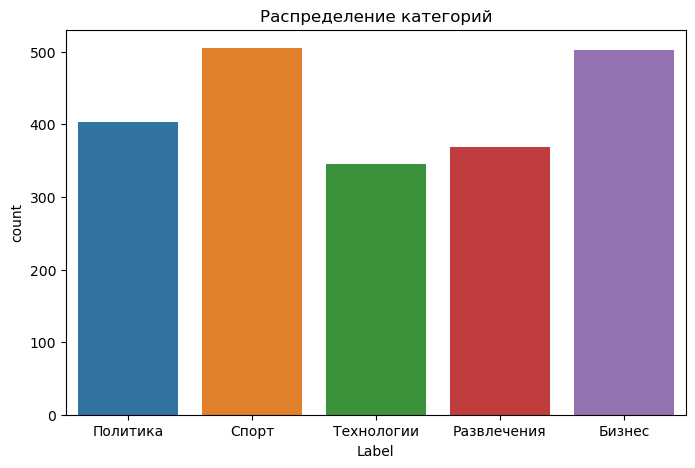

In [513]:
# Вывод количества значений в столбце 'Label' и их сортировка по индексу
print(df.Label.value_counts().sort_index())

# Создание графика с помощью subplots() с указанием размеров
fig, ax = plt.subplots(figsize=(8, 5))

# Построение столбчатой диаграммы с использованием библиотеки seaborn
sns.barplot(x=df.Label.value_counts().index, y=df.Label.value_counts(), ax=ax)

# Установка заголовка графика
ax.set_title("Распределение категорий")

# Установка подписей оси x для соответствующих категорий
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])

# Отображение графика
plt.show()

In [514]:
# Выведем первый текст из набора
df.Text[0]

'Бюджет для создания условий для выборов\n \n Гордон Браун постарается поставить экономику в центр предложения лейбористов на третий срок, когда он представит свой девятый бюджет в 12:30 по Гринвичу. Ожидается, что он подчеркнет важность сохранения экономической стабильности при низких уровнях безработицы и процентных ставок. Ожидается, что канцлер заморозит пошлину на бензин и повысит порог гербового тарифа с 60 000 фунтов стерлингов. Но консерваторы и Либ Демс настаивают на том, что избиратели сталкиваются с более высокими налогами и с большим количеством проверок материального положения в рамках трудового законодательства.\n \n Казначейские чиновники сказали, что не будет предвыборной передачи, но мистеру Брауну, как предполагается, осталось около 2 млрд. фунтов стерлингов.\n \n - повышение порога гербового сбора с 60 000 фунтов стерлингов; \n  - Заморозка бензина \n  - расширение системы налоговых кредитов для более бедных семей; \n  - Возможная помощь пенсионерам: повышение порого

## Очистка текста (1 метод - без лемматизации, стемминга и n-грамм)

In [515]:
def clean_text1(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    text = " ".join(text)
    return text

df["cleaned_text"] = df["Text"].apply(clean_text1)

In [516]:
# Получение уникальных меток
labels = df["Label"].unique()

# Словарь для подсчета количества слов в каждой теме
word_counts = {label: {} for label in labels}

# Заполнение словаря
for label in labels:
    texts = df[df["Label"] == label]["cleaned_text"]
    for text in texts:
        words = text.split()
        for word in words:
            if word in word_counts[label]:
                word_counts[label][word] += 1
            else:
                word_counts[label][word] = 1

# Преобразование в DataFrame
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index').fillna(0).astype(int)

# Транспонирование таблицы для удобства
word_counts_df = word_counts_df.T

# Выбираем строки, где значения столбцов отличаются не более чем на 10%
# Коэффициент изменения (30% в данном случае)
percent_change_threshold = 0.3

# Функция для проверки условия
def within_threshold(row):
    min_value = row.min()
    max_value = row.max()
    return (max_value - min_value) / max_value <= percent_change_threshold

# Выборка строк
selected_rows = word_counts_df[word_counts_df.apply(within_threshold, axis=1)]
##### !!!!!!! df["cleaned_text"] = df["cleaned_text"].apply(lambda x: " ".join([i for i in x.split() if not i in selected_rows.index.tolist()]))
selected_rows

0    2    3    4    1
время          346  389  317  429  406
пяти            24   27   25   29   22
эриком           1    1    1    1    1
большой         47   41   47   48   53
слухи            7    8    6    7    6
протяжении      23   21   19   25   25
предыдущие       6    6    7    8    6
ричард          10    9   12   11   10
спасти           7    6    6    8    7
пойман           1    1    1    1    1
сохраняют        1    1    1    1    1
большими         3    4    3    4    4
сроком           1    1    1    1    1
подтвердило      1    1    1    1    1
тянет            1    1    1    1    1
предотвратили    1    1    1    1    1
перешли          1    1    1    1    1
называемым       1    1    1    1    1
критериев        1    1    1    1    1

In [517]:
df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  
0  бюджет создания условий выборов гордон браун п...  
1  армейские вожди составе полков ожидается военн...  
2  говард отрицает разбивку удостоверения личност...  
3  наблюдатели выборами соединенном королевстве м...  
4  килрой назвал выборное место бывший организато...

## Статистика по тексту

In [518]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  word_count  text_length  \
0  бюджет создания условий выборов гордон браун п...         343         2983   
1  армейские вожди составе полков ожидается военн...         288         2559   
2  говард отрицает разбивку удостоверения личност...         331         2837   
3  наблюдатели выборами соединенном королевстве м...         340         3089   
4  килрой назвал выборное место бывший организато...         274         2274   

   stopwords_count  punct_count  caps_count  
0              108           86          57  
1              106           83          46  
2              123          109          63  
3              131           81          56  
4              106           96         109

In [519]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

word_count  text_length  stopwords_count  punct_count  caps_count
0  279.034739  2404.538462       111.652605    88.933002   60.119107
1  182.976238  1447.794059        82.200000    68.780198   63.982178
2  297.939130  2577.060870       113.455072    98.449275   72.304348
3  191.439024  1538.230352        72.604336    66.910569   67.260163
4  209.658052  1794.763419        72.391650    68.817097   55.952286

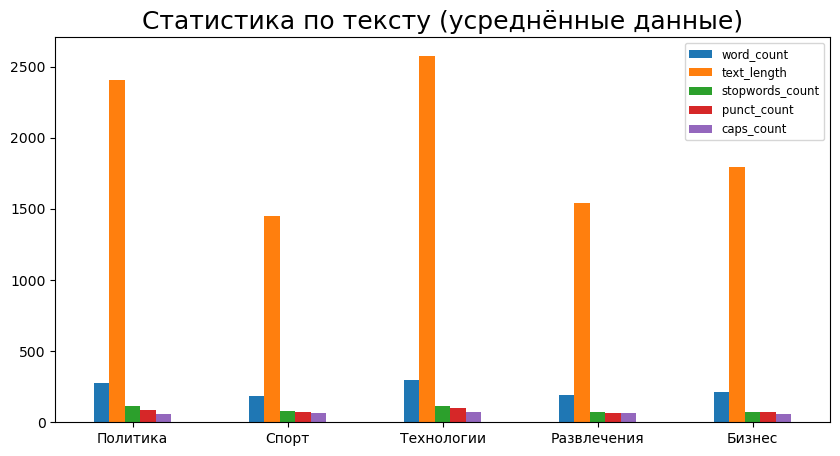

In [520]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

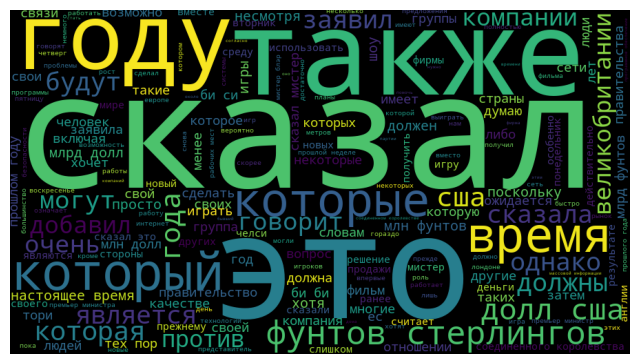

In [521]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [522]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

абсолютно  аварии  августа  августе  авиакомпании  авиакомпаний  \
0          0       0        0        0             0             0   
1          0       0        0        0             0             0   
2          0       0        0        0             0             0   
3          0       0        0        0             0             0   
4          0       0        0        0             0             0   

   авиакомпания  авиатор  австралии  австралийский  ...  ян  январе  января  \
0             0        0          0              0  ...   0       0       0   
1             0        0          0              0  ...   0       0       0   
2             0        0          0              0  ...   0       0       0   
3             0        0          0              0  ...   0       0       0   
4             0        0          0              0  ...   0       0       0   

   янг  японии  япония  японская  японский  ярдов  ясно  
0    0       0       0         0         0      0     0  
1    0       0       0         0         0      0     0  
2    0       0       0         0         0      0     0  
3    0       0       0         0         0      0     0  
4    0       0       0         0         0      0     1  

[5 rows x 5000 columns]

In [523]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count
0      0         343         2983              108           86          57
1      0         288         2559              106           83          46
2      0         331         2837              123          109          63
3      0         340         3089              131           81          56
4      0         274         2274              106           96         109

In [524]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0         343         2983              108           86          57   
1      0         288         2559              106           83          46   
2      0         331         2837              123          109          63   
3      0         340         3089              131           81          56   
4      0         274         2274              106           96         109   

   абсолютно  аварии  августа  августе  ...  ян  январе  января  янг  японии  \
0          0       0        0        0  ...   0       0       0    0       0   
1          0       0        0        0  ...   0       0       0    0       0   
2          0       0        0        0  ...   0       0       0    0       0   
3          0       0        0        0  ...   0       0       0    0       0   
4          0       0        0        0  ...   0       0       0    0       0   

   япония  японская  японский  ярдов  ясно  
0       0         0         0      0     0  
1       0         0         0      0     0  
2       0         0         0      0     0  
3       0         0         0      0     0  
4       0         0         0      0     1  

[5 rows x 5006 columns]

## RandomUnderSampler

In [525]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

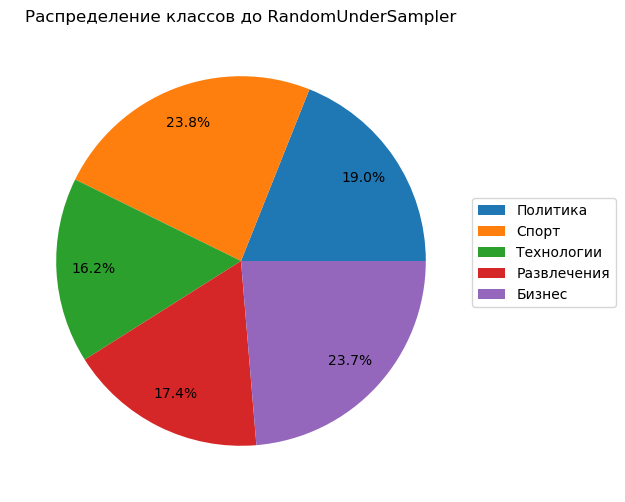

In [526]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [527]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

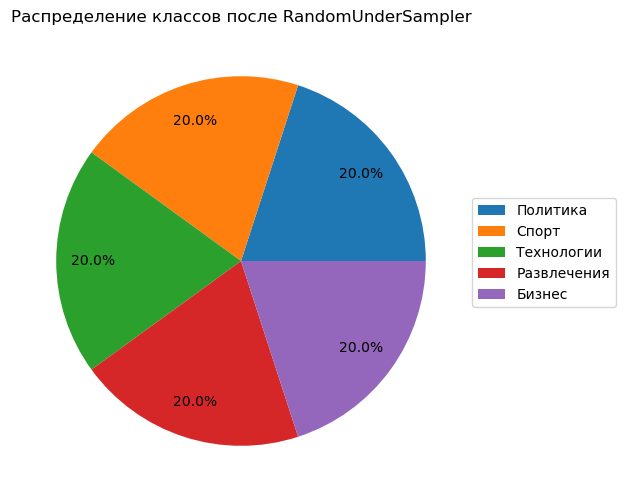

In [528]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [529]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [530]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [531]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [532]:
#######  Logistic Regression  #######
log_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=5)
log_grid_search.fit(X_train_scaled, y_train)
log_best_params = log_grid_search.best_params_

log = LogisticRegression(**log_best_params).fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf_param_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_params = rf_grid_search.best_params_

rf = RandomForestClassifier(**rf_best_params).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 4, 5],
                  'learning_rate': [0.1, 0.01, 0.001]}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid_search.best_params_

xgb = XGBClassifier(**xgb_best_params).fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm_param_grid = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'verbosity': [-1]}
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train_scaled, y_train)
lgbm_best_params = lgbm_grid_search.best_params_

lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
# CatBoost имеет встроенную настройку гиперпараметров, поэтому GridSearchCV не нужен
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
# Преобразование данных в тензоры float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры для поиска
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

net = NeuralNetClassifier(
    NeuralNetwork,
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    module__input_size=input_size,
    module__hidden_size=64,
    module__num_classes=num_classes,
    verbose=0
)

# Определение параметров для Grid Search
params = {
    'net__lr': [0.001, 0.01],
    'net__max_epochs': [50, 100],
    'net__module__hidden_size': [32, 64, 128],
}

# Pipeline и Grid Search
pipe = Pipeline([('net', net)])
gs = GridSearchCV(pipe, params, refit=True, cv=3, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
gs.fit(X_train_scaled.astype(np.float32), y_train.values)

# Лучшая модель
best_model = gs.best_estimator_.named_steps['net']

# Прогнозирование на тестовых данных
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    outputs = best_model.forward(X_test_scaled_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### Расчёт accuracy

In [533]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9633204633204633, 0.9305019305019305, 0.9324324324324325, 0.9478764478764479, 0.944015444015444, 0.9633204633204633]


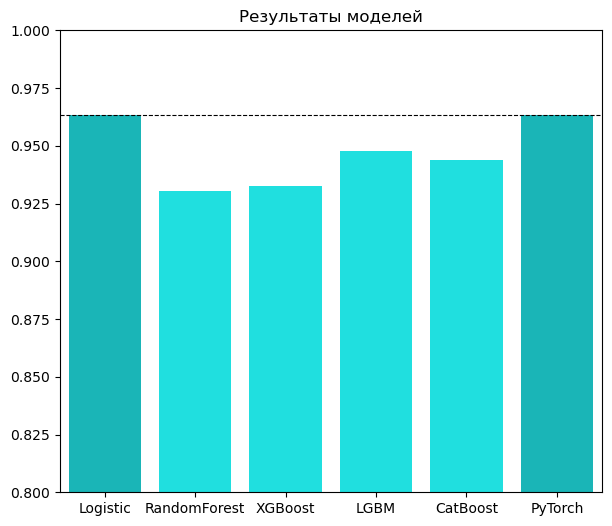

In [534]:
accuracy_list1 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list1)) else "darkturquoise" for i in accuracy_list1]
sns.barplot(x=np.arange(0,6), y=accuracy_list1, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list1)
plt.show()

In [535]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.96      0.97      0.96        95
           1       1.00      0.99      1.00       112
           2       0.96      0.95      0.96       101
           3       0.95      0.97      0.96       104
           4       0.94      0.93      0.94       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



In [536]:
# Вычисление классификационного отчета
class_report_pytorch = classification_report(y_test, y_pred_pytorch)

print("############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############\n")
print(class_report_pytorch)

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        95
           1       1.00      1.00      1.00       112
           2       0.94      0.96      0.95       101
           3       0.96      0.95      0.96       104
           4       0.95      0.92      0.94       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самые важные факторы

In [537]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

feature_importance         features
0                 746       caps_count
1                 574      text_length
2                 441  stopwords_count
3                 417      punct_count
4                 395       word_count

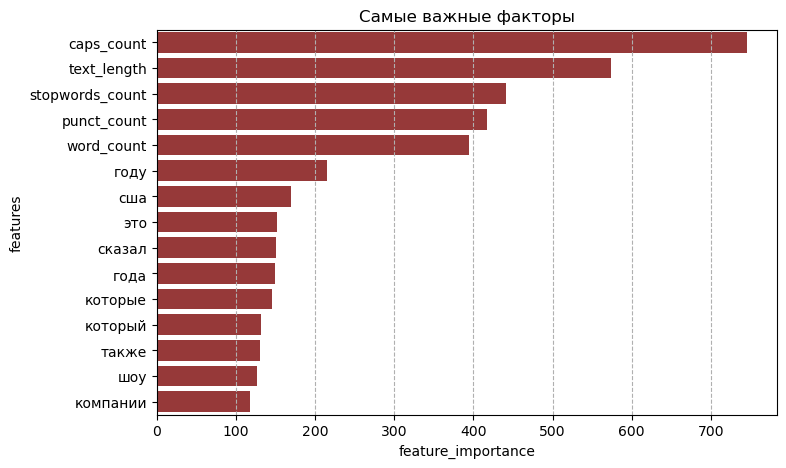

In [538]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самые важные факторы")
plt.grid(axis="x", ls="--")
plt.show()

**_Результаты рейтинга, приведенные выше, объясняют важность статистики слов._**

## Очистка текста (1.1 метод - без лемматизации, стемминга и n-грамм, с выделением заголовка)

In [539]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text11(text):
    text = text.split('\n', 1)[-1]
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    text = " ".join(text)
    return text

def get_title(text):
    text = text.split('\n', 1)[0]
    return text
    
df["title"] = df["Text"].apply(get_title)
df["cleaned_title"] = df["title"].apply(clean_text1)
df["cleaned_text"] = df["Text"].apply(clean_text11)

In [540]:
df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                               title  \
0            Бюджет для создания условий для выборов   
1                   Армейские вожди в составе полков   
2  Говард отрицает разбивку на удостоверения личн...   
3  Наблюдатели за выборами в Соединенном Королевстве   
4                       Килрой назвал выборное место   

                                     cleaned_title  \
0                  бюджет создания условий выборов   
1                   армейские вожди составе полков   
2  говард отрицает разбивку удостоверения личности   
3     наблюдатели выборами соединенном королевстве   
4                     килрой назвал выборное место   

                                        cleaned_text  
0  гордон браун постарается поставить экономику ц...  
1  ожидается военные вожди встретятся принять око...  
2  майкл говард отрицал теневой кабинет разделен ...  
3  министры пригласят международных наблюдателей ...  
4  бывший организатор шоу роберт килрой силк учас...

## Статистика по тексту

In [541]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["title_word_count"] = df["cleaned_title"].apply(lambda x: len(x.split()))

df["title_text_length"] = df["cleaned_title"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df["title_stopwords_count"] = df["title"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["title_punct_count"] = df["title"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["title_caps_count"] = df["title"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                               title  \
0            Бюджет для создания условий для выборов   
1                   Армейские вожди в составе полков   
2  Говард отрицает разбивку на удостоверения личн...   
3  Наблюдатели за выборами в Соединенном Королевстве   
4                       Килрой назвал выборное место   

                                     cleaned_title  \
0                  бюджет создания условий выборов   
1                   армейские вожди составе полков   
2  говард отрицает разбивку удостоверения личности   
3     наблюдатели выборами соединенном королевстве   
4                     килрой назвал выборное место   

                                        cleaned_text  word_count  text_length  \
0  гордон браун постарается поставить экономику ц...         339         2951   
1  ожидается военные вожди встретятся принять око...         284         2528   
2  майкл говард отрицал теневой кабинет разделен ...         326         2789   
3  министры пригласят международных наблюдателей ...         336         3044   
4  бывший организатор шоу роберт килрой силк учас...         270         2245   

   title_word_count  title_text_length  stopwords_count  punct_count  \
0                 4                 31              108           86   
1                 4                 30              106           83   
2                 5                 47              123          109   
3                 4                 44              131           81   
4                 4                 28              106           96   

   caps_count  title_stopwords_count  title_punct_count  title_caps_count  
0          57                      2                  0                 1  
1          46                      1                  0                 1  
2          63                      1                  0                 1  
3          56                      2                  0                 3  
4         109                      0                  0                 1

In [542]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

word_count  text_length  stopwords_count  punct_count  caps_count
0  274.605459  2366.823821       111.652605    88.933002   60.119107
1  179.118812  1416.279208        82.200000    68.780198   63.982178
2  293.684058  2540.872464       113.455072    98.449275   72.304348
3  187.195122  1504.650407        72.604336    66.910569   67.260163
4  204.912525  1755.532803        72.391650    68.817097   55.952286

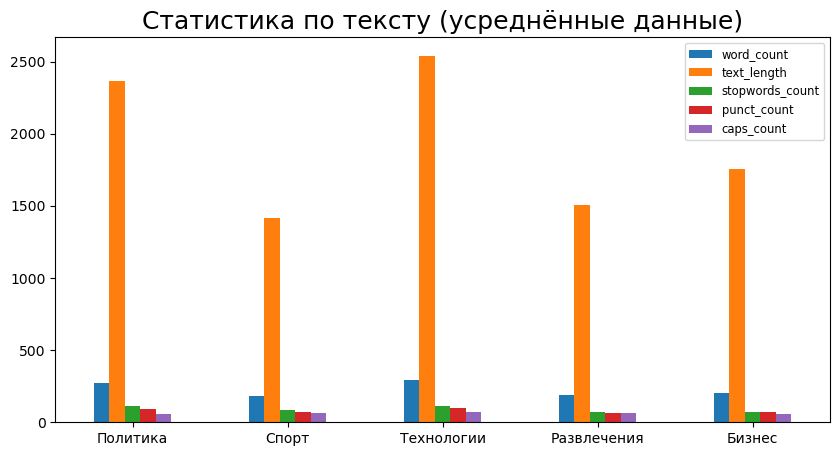

In [543]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

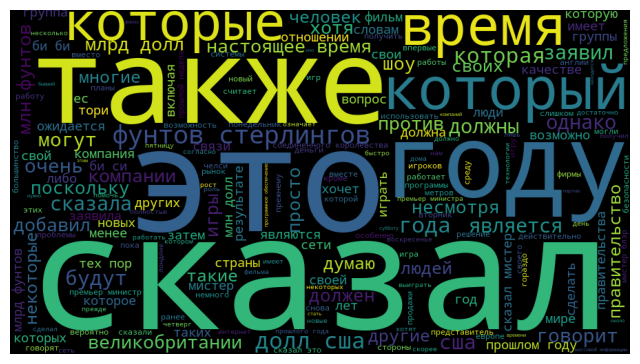

In [544]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

In [545]:
grouped_title = df.groupby("Label").agg({"title_word_count": "mean",
                                        "title_text_length": "mean",
                                        "title_stopwords_count": "mean",
                                        "title_punct_count": "mean",
                                        "title_caps_count": "mean"})
grouped_title = grouped_title.reset_index(drop=True)
grouped_title

title_word_count  title_text_length  title_stopwords_count  \
0          4.429280          36.714640               0.893300   
1          3.857426          30.518812               0.732673   
2          4.255072          35.188406               0.753623   
3          4.243902          32.579946               0.636856   
4          4.745527          38.230616               0.898608   

   title_punct_count  title_caps_count  
0           0.908189          1.776675  
1           0.665347          1.950495  
2           0.907246          1.788406  
3           0.967480          2.338753  
4           0.972167          2.298211

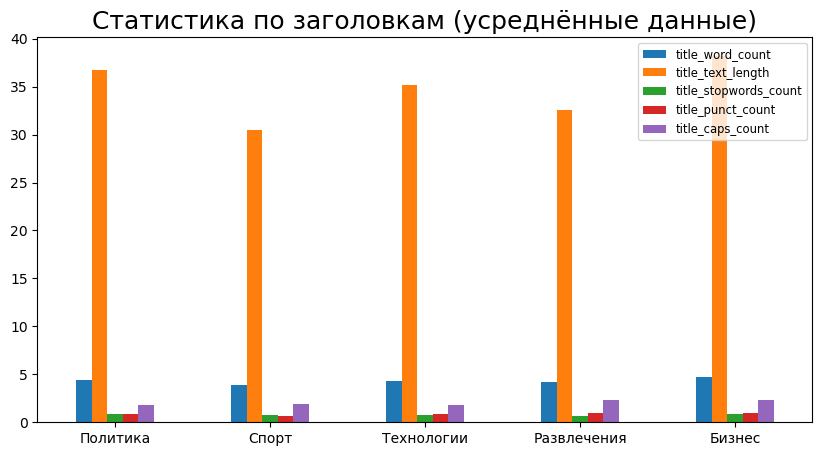

In [546]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_title.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по заголовкам (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

## Вывод по статистике по заголовкам

По диаграмме видно, что статистические данные заголовков текстов всех категорий примерно одинаковы, значит, их можно не учитывать при обучении.

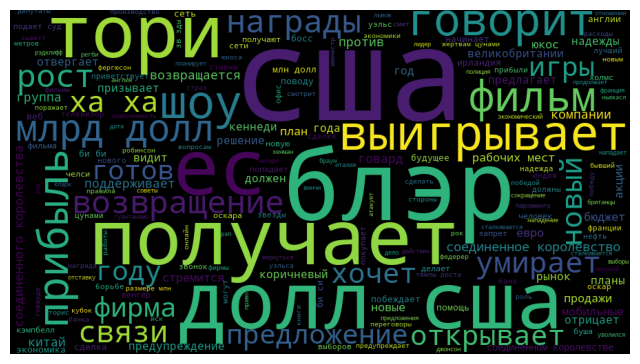

In [547]:
all_cleaned_title = " ".join(df["cleaned_title"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_title)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [548]:
count_vec1 = CountVectorizer(max_features=5000)
count_array1 = count_vec1.fit_transform(df["cleaned_text"]).toarray()
df_count_vec1 = pd.DataFrame(count_array1, columns=count_vec1.get_feature_names_out())
df_count_vec1 = df_count_vec1.reset_index(drop=True)
df_count_vec1.head()

абсолютно  августа  августе  авиакомпании  авиакомпаний  авиакомпания  \
0          0        0        0             0             0             0   
1          0        0        0             0             0             0   
2          0        0        0             0             0             0   
3          0        0        0             0             0             0   
4          0        0        0             0             0             0   

   авиатор  австралии  австралийский  австралийских  ...  якобы  ян  январе  \
0        0          0              0              0  ...      0   0       0   
1        0          0              0              0  ...      0   0       0   
2        0          0              0              0  ...      0   0       0   
3        0          0              0              0  ...      0   0       0   
4        0          0              0              0  ...      0   0       0   

   января  янг  японии  япония  японская  ярдов  ясно  
0       0    0       0       0         0      0     0  
1       0    0       0       0         0      0     0  
2       0    0       0       0         0      0     0  
3       0    0       0       0         0      0     0  
4       0    0       0       0         0      0     1  

[5 rows x 5000 columns]

In [549]:
df1 = df.iloc[:, [1,5,6,9,10,11]]
df1 = df1.reset_index(drop=True)
df1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count
0      0         339         2951              108           86          57
1      0         284         2528              106           83          46
2      0         326         2789              123          109          63
3      0         336         3044              131           81          56
4      0         270         2245              106           96         109

In [550]:
df_nlp1 = pd.concat([df1, df_count_vec1], axis=1)
df_nlp1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0         339         2951              108           86          57   
1      0         284         2528              106           83          46   
2      0         326         2789              123          109          63   
3      0         336         3044              131           81          56   
4      0         270         2245              106           96         109   

   абсолютно  августа  августе  авиакомпании  ...  якобы  ян  январе  января  \
0          0        0        0             0  ...      0   0       0       0   
1          0        0        0             0  ...      0   0       0       0   
2          0        0        0             0  ...      0   0       0       0   
3          0        0        0             0  ...      0   0       0       0   
4          0        0        0             0  ...      0   0       0       0   

   янг  японии  япония  японская  ярдов  ясно  
0    0       0       0         0      0     0  
1    0       0       0         0      0     0  
2    0       0       0         0      0     0  
3    0       0       0         0      0     0  
4    0       0       0         0      0     1  

[5 rows x 5006 columns]

## CountVectorizer для заголовков

In [551]:
count_vec2 = CountVectorizer(max_features=5000)
count_array2 = count_vec2.fit_transform(df["cleaned_title"]).toarray()
df_count_vec2 = pd.DataFrame(count_array2, columns=(count_vec2.get_feature_names_out() + "_title"))
df_count_vec2 = df_count_vec2.reset_index(drop=True)
df_count_vec2.head()

ааа_title  аалийя_title  абба_title  аббас_title  абердин_title  \
0          0             0           0            0              0   
1          0             0           0            0              0   
2          0             0           0            0              0   
3          0             0           0            0              0   
4          0             0           0            0              0   

   абонентские_title  аборты_title  абса_title  абсолютная_title  \
0                  0             0           0                 0   
1                  0             0           0                 0   
2                  0             0           0                 0   
3                  0             0           0                 0   
4                  0             0           0                 0   

   аварии_title  ...  японские_title  японский_title  японского_title  \
0             0  ...               0               0                0   
1             0  ...               0               0                0   
2             0  ...               0               0                0   
3             0  ...               0               0                0   
4             0  ...               0               0                0   

   яппа_title  ярлык_title  ярлыков_title  ярмарке_title  ярмарку_title  \
0           0            0              0              0              0   
1           0            0              0              0              0   
2           0            0              0              0              0   
3           0            0              0              0              0   
4           0            0              0              0              0   

   яху_title  ящика_title  
0          0            0  
1          0            0  
2          0            0  
3          0            0  
4          0            0  

[5 rows x 5000 columns]

In [552]:
# df2 = df.iloc[:, [7,8,12,13,14]] # df2 = df.iloc[:, [3,7,8,12,13,14]]
# df2 = df2.reset_index(drop=True)
# df2.head()

# По диаграмме видно, что статистические данные заголовков текстов всех категорий примерно одинаковы, 
# значит, их можно не учитывать при обучении.

In [553]:
df_nlp2 = pd.concat([df_nlp1, df_count_vec2], axis=1)
df_nlp2.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0         339         2951              108           86          57   
1      0         284         2528              106           83          46   
2      0         326         2789              123          109          63   
3      0         336         3044              131           81          56   
4      0         270         2245              106           96         109   

   абсолютно  августа  августе  авиакомпании  ...  японские_title  \
0          0        0        0             0  ...               0   
1          0        0        0             0  ...               0   
2          0        0        0             0  ...               0   
3          0        0        0             0  ...               0   
4          0        0        0             0  ...               0   

   японский_title  японского_title  яппа_title  ярлык_title  ярлыков_title  \
0               0                0           0            0              0   
1               0                0           0            0              0   
2               0                0           0            0              0   
3               0                0           0            0              0   
4               0                0           0            0              0   

   ярмарке_title  ярмарку_title  яху_title  ящика_title  
0              0              0          0            0  
1              0              0          0            0  
2              0              0          0            0  
3              0              0          0            0  
4              0              0          0            0  

[5 rows x 10006 columns]

## RandomUnderSampler

In [554]:
y = df_nlp2["Label"]
X = df_nlp2.drop("Label", axis=1)

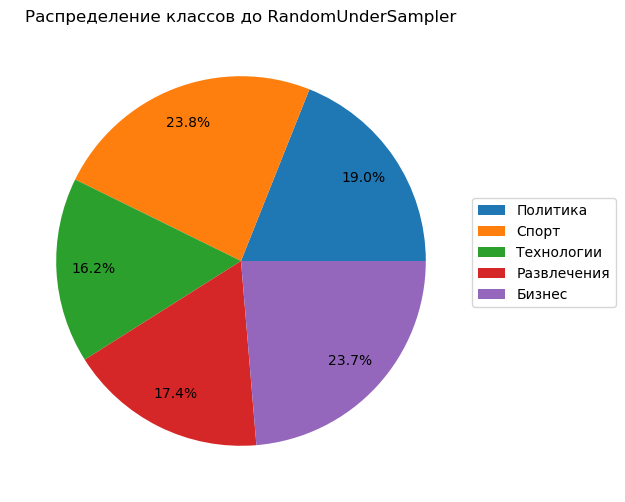

In [555]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [556]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

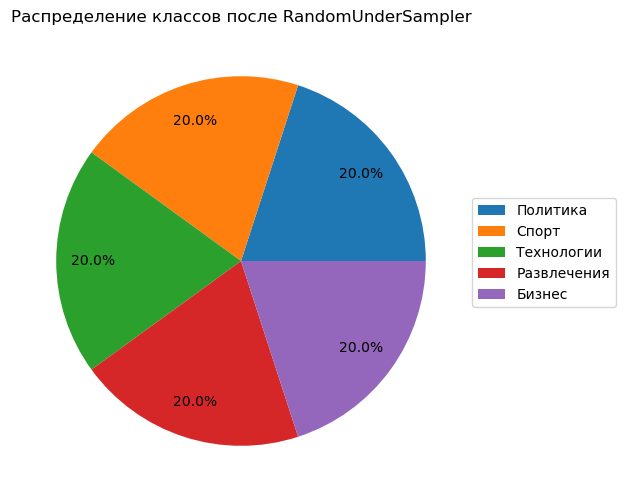

In [557]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [558]:
print(X.shape)
print(y.shape)

(1725, 10005)
(1725,)


### train/test - разделение

In [559]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [560]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [561]:
#######  Logistic Regression  #######
log_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=5)
log_grid_search.fit(X_train_scaled, y_train)
log_best_params = log_grid_search.best_params_

log = LogisticRegression(**log_best_params).fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf_param_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_params = rf_grid_search.best_params_

rf = RandomForestClassifier(**rf_best_params).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 4, 5],
                  'learning_rate': [0.1, 0.01, 0.001]}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid_search.best_params_

xgb = XGBClassifier(**xgb_best_params).fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm_param_grid = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'verbosity': [-1]}
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train_scaled, y_train)
lgbm_best_params = lgbm_grid_search.best_params_

lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
# CatBoost имеет встроенную настройку гиперпараметров, поэтому GridSearchCV не нужен
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
# Преобразование данных в тензоры float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры для поиска
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

net = NeuralNetClassifier(
    NeuralNetwork,
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    module__input_size=input_size,
    module__hidden_size=64,
    module__num_classes=num_classes,
    verbose=0
)

# Определение параметров для Grid Search
params = {
    'net__lr': [0.001, 0.01],
    'net__max_epochs': [50, 100],
    'net__module__hidden_size': [32, 64, 128],
}

# Pipeline и Grid Search
pipe = Pipeline([('net', net)])
gs = GridSearchCV(pipe, params, refit=True, cv=3, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
gs.fit(X_train_scaled.astype(np.float32), y_train.values)

# Лучшая модель
best_model = gs.best_estimator_.named_steps['net']

# Прогнозирование на тестовых данных
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    outputs = best_model.forward(X_test_scaled_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### Расчёт accuracy

In [562]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9613899613899614, 0.9324324324324325, 0.9343629343629344, 0.944015444015444, 0.9459459459459459, 0.9575289575289575]


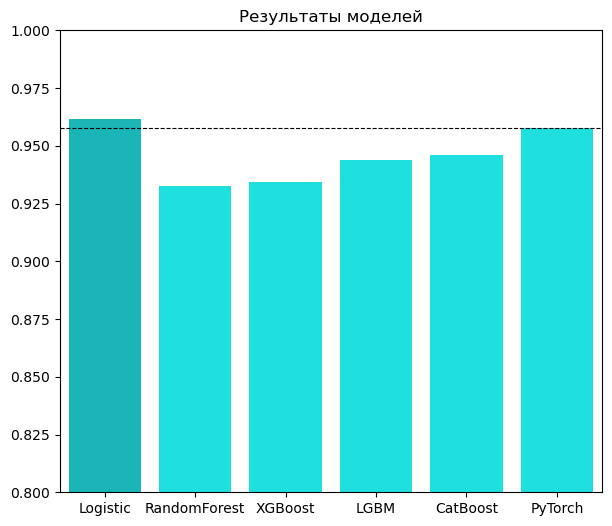

In [563]:
accuracy_list11 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list11)) else "darkturquoise" for i in accuracy_list11]
sns.barplot(x=np.arange(0,6), y=accuracy_list11, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list11)
plt.show()

## Вывод по применению метода выделения заголовков

По результатам при выделении заголовков accuracy уменьшилась, поэтому последующие методы будем исползовать без выделения заголовков.

## Очистка текста (2 метод - лемматизация)

In [564]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text2(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    mystem = Mystem()
    text = [mystem.lemmatize(word)[0] for word in text]
    text = " ".join(text)
    return text

df["cleaned_text"] = df["Text"].apply(clean_text2)

In [565]:
df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  
0  бюджет создание условие выбор гордон браун пос...  
1  армейский вождь состав полк ожидаться военный ...  
2  говард отрицать разбивка удостоверение личност...  
3  наблюдатель выборы соединять королевство минис...  
4  килрой называть выборный место бывший организа...

## Статистика по тексту

In [566]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  word_count  text_length  \
0  бюджет создание условие выбор гордон браун пос...         343         2928   
1  армейский вождь состав полк ожидаться военный ...         288         2521   
2  говард отрицать разбивка удостоверение личност...         331         2867   
3  наблюдатель выборы соединять королевство минис...         340         3014   
4  килрой называть выборный место бывший организа...         274         2269   

   stopwords_count  punct_count  caps_count  
0              108           86          57  
1              106           83          46  
2              123          109          63  
3              131           81          56  
4              106           96         109

In [567]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

word_count  text_length  stopwords_count  punct_count  caps_count
0  279.034739  2380.692308       111.652605    88.933002   60.119107
1  182.976238  1446.796040        82.200000    68.780198   63.982178
2  297.939130  2543.542029       113.455072    98.449275   72.304348
3  191.439024  1524.146341        72.604336    66.910569   67.260163
4  209.658052  1768.914513        72.391650    68.817097   55.952286

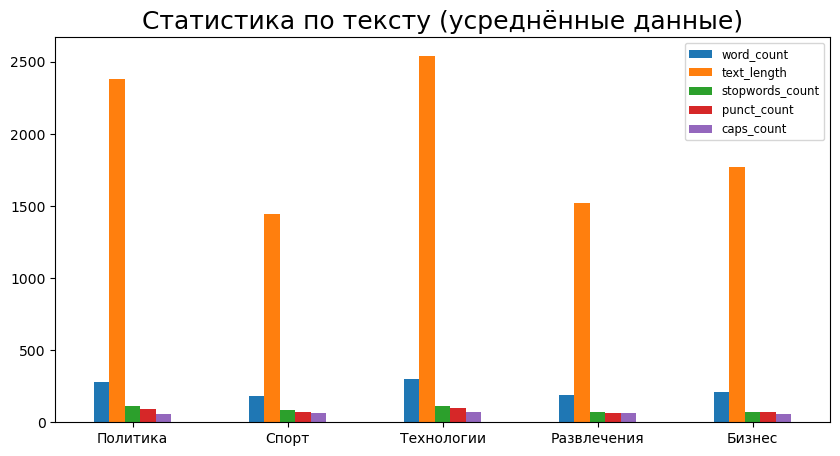

In [568]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

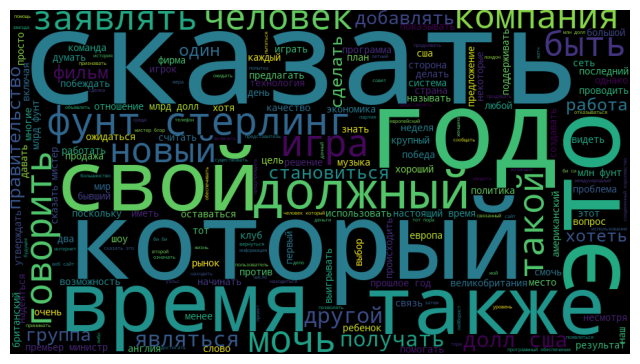

In [569]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [570]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

аборт  абсолютно  абсолютный  авария  август  авиакомпания  авиатор  \
0      0          0           0       0       0             0        0   
1      0          0           0       0       0             0        0   
2      0          0           0       0       0             0        0   
3      0          0           0       0       0             0        0   
4      0          0           0       0       0             0        0   

   авиация  авива  австралийский  ...  ярд  яркий  ярлык  ярмарка  ясно  \
0        0      0              0  ...    0      0      0        0     0   
1        0      0              0  ...    0      0      0        0     0   
2        0      0              0  ...    0      0      0        0     0   
3        0      0              0  ...    0      0      0        0     0   
4        0      0              0  ...    0      0      0        0     1   

   ясный  яху  ячвили  ячейка  ящик  
0      0    0       0       0     0  
1      0    0       0       0     0  
2      0    0       0       0     0  
3      0    0       0       0     0  
4      0    0       0       0     0  

[5 rows x 5000 columns]

In [571]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count
0      0         343         2928              108           86          57
1      0         288         2521              106           83          46
2      0         331         2867              123          109          63
3      0         340         3014              131           81          56
4      0         274         2269              106           96         109

In [572]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0         343         2928              108           86          57   
1      0         288         2521              106           83          46   
2      0         331         2867              123          109          63   
3      0         340         3014              131           81          56   
4      0         274         2269              106           96         109   

   аборт  абсолютно  абсолютный  авария  ...  ярд  яркий  ярлык  ярмарка  \
0      0          0           0       0  ...    0      0      0        0   
1      0          0           0       0  ...    0      0      0        0   
2      0          0           0       0  ...    0      0      0        0   
3      0          0           0       0  ...    0      0      0        0   
4      0          0           0       0  ...    0      0      0        0   

   ясно  ясный  яху  ячвили  ячейка  ящик  
0     0      0    0       0       0     0  
1     0      0    0       0       0     0  
2     0      0    0       0       0     0  
3     0      0    0       0       0     0  
4     1      0    0       0       0     0  

[5 rows x 5006 columns]

## RandomUnderSampler

In [573]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

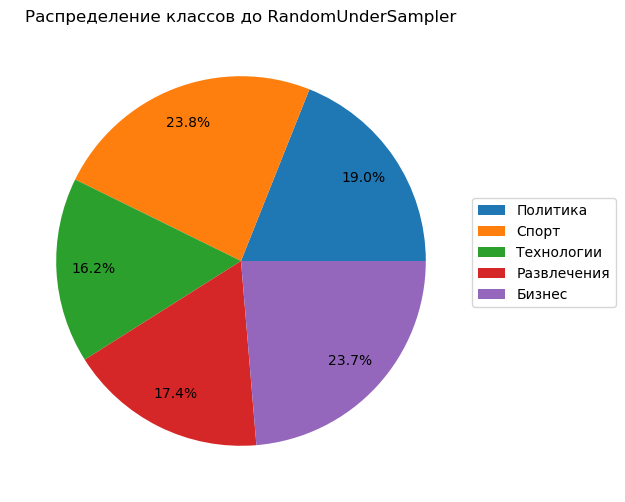

In [574]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [575]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

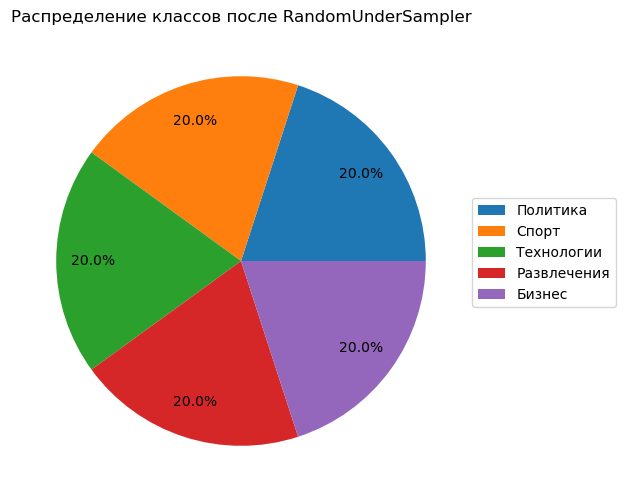

In [576]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [577]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [578]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [579]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [580]:
#######  Logistic Regression  #######
log_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=5)
log_grid_search.fit(X_train_scaled, y_train)
log_best_params = log_grid_search.best_params_

log = LogisticRegression(**log_best_params).fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf_param_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_params = rf_grid_search.best_params_

rf = RandomForestClassifier(**rf_best_params).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 4, 5],
                  'learning_rate': [0.1, 0.01, 0.001]}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid_search.best_params_

xgb = XGBClassifier(**xgb_best_params).fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm_param_grid = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'verbosity': [-1]}
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train_scaled, y_train)
lgbm_best_params = lgbm_grid_search.best_params_

lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
# CatBoost имеет встроенную настройку гиперпараметров, поэтому GridSearchCV не нужен
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
# Преобразование данных в тензоры float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры для поиска
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

net = NeuralNetClassifier(
    NeuralNetwork,
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    module__input_size=input_size,
    module__hidden_size=64,
    module__num_classes=num_classes,
    verbose=0
)

# Определение параметров для Grid Search
params = {
    'net__lr': [0.001, 0.01],
    'net__max_epochs': [50, 100],
    'net__module__hidden_size': [32, 64, 128],
}

# Pipeline и Grid Search
pipe = Pipeline([('net', net)])
gs = GridSearchCV(pipe, params, refit=True, cv=3, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
gs.fit(X_train_scaled.astype(np.float32), y_train.values)

# Лучшая модель
best_model = gs.best_estimator_.named_steps['net']

# Прогнозирование на тестовых данных
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    outputs = best_model.forward(X_test_scaled_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### Расчёт accuracy

In [581]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9575289575289575, 0.9498069498069498, 0.9420849420849421, 0.9459459459459459, 0.9401544401544402, 0.9633204633204633]


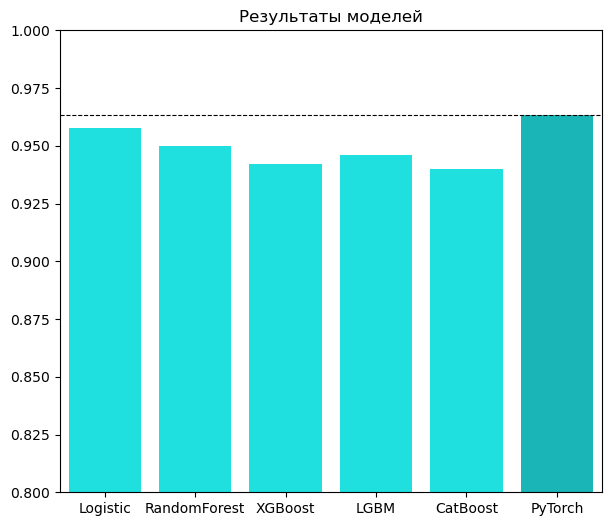

In [582]:
accuracy_list2 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list2)) else "darkturquoise" for i in accuracy_list2]
sns.barplot(x=np.arange(0,6), y=accuracy_list2, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list2)
plt.show()

In [583]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.93      0.97      0.95        95
           1       1.00      1.00      1.00       112
           2       0.96      0.96      0.96       101
           3       0.94      0.96      0.95       104
           4       0.95      0.90      0.92       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



In [584]:
# Вычисление классификационного отчета
class_report_pytorch = classification_report(y_test, y_pred_pytorch)

print("############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############\n")
print(class_report_pytorch)

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        95
           1       0.99      1.00      1.00       112
           2       0.95      0.97      0.96       101
           3       0.97      0.95      0.96       104
           4       0.96      0.92      0.94       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самые важные факторы

In [585]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

feature_importance         features
0                 316      text_length
1                 302       caps_count
2                 244              год
3                 236       word_count
4                 219  stopwords_count

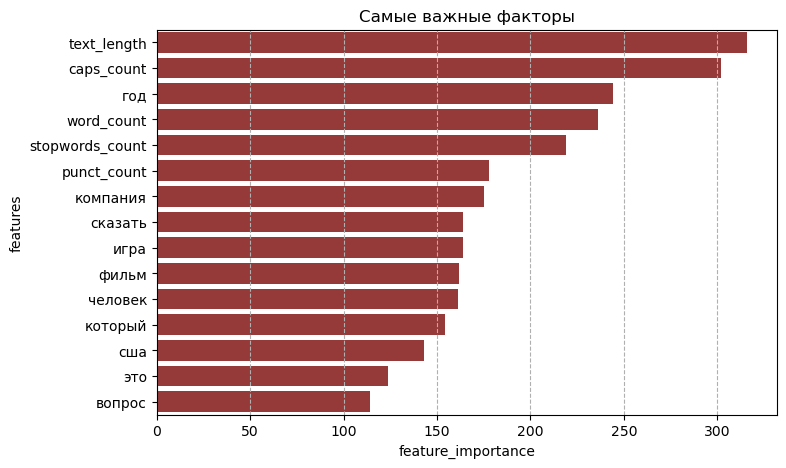

In [586]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самые важные факторы")
plt.grid(axis="x", ls="--")
plt.show()

### Очистка текста (3 метод - стемминг)

In [587]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text3(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    stemmer = snowballstemmer.stemmer('russian')
    text = [stemmer.stemWord(word) for word in text]    
    text = " ".join(text)
    return text

df["cleaned_text"] = df["Text"].apply(clean_text3)

In [588]:
df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  
0  бюджет создан услов выбор гордон браун постара...  
1  армейск вожд состав полк ожида воен вожд встре...  
2  говард отрица разбивк удостоверен личност майк...  
3  наблюдател выбор соединен королевств министр п...  
4  килр назва выборн мест бывш организатор шо роб...

## Статистика по тексту

In [589]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  word_count  text_length  \
0  бюджет создан услов выбор гордон браун постара...         343         2435   
1  армейск вожд состав полк ожида воен вожд встре...         288         2067   
2  говард отрица разбивк удостоверен личност майк...         331         2326   
3  наблюдател выбор соединен королевств министр п...         340         2505   
4  килр назва выборн мест бывш организатор шо роб...         274         1848   

   stopwords_count  punct_count  caps_count  
0              108           86          57  
1              106           83          46  
2              123          109          63  
3              131           81          56  
4              106           96         109

In [590]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

word_count  text_length  stopwords_count  punct_count  caps_count
0  279.034739  1953.200993       111.652605    88.933002   60.119107
1  182.976238  1180.607921        82.200000    68.780198   63.982178
2  297.939130  2074.637681       113.455072    98.449275   72.304348
3  191.439024  1253.964770        72.604336    66.910569   67.260163
4  209.658052  1455.335984        72.391650    68.817097   55.952286

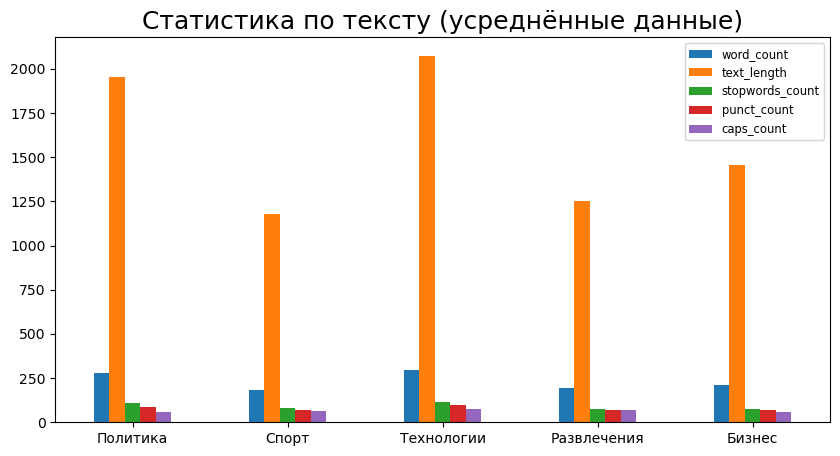

In [591]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

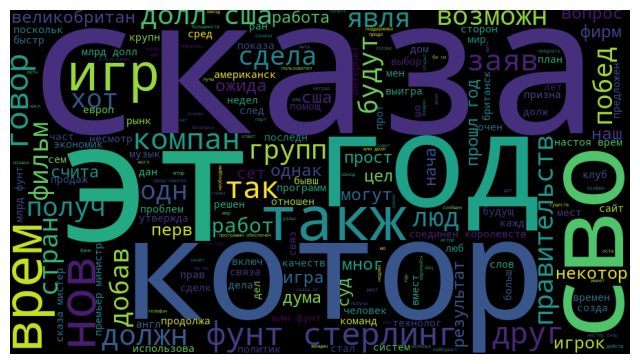

In [592]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [593]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

аббас  аборт  абсолютн  авар  август  авиакомпан  авиатор  авиац  авив  \
0      0      0         0     0       0           0        0      0     0   
1      0      0         0     0       0           0        0      0     0   
2      0      0         0     0       0           0        0      0     0   
3      0      0         0     0       0           0        0      0     0   
4      0      0         0     0       0           0        0      0     0   

   австр  ...  японск  ярд  ярк  ярлык  ярмарк  ясн  ях  ячв  ячейк  ящик  
0      0  ...       0    0    0      0       0    0   0    0      0     0  
1      0  ...       0    0    0      0       0    0   0    0      0     0  
2      0  ...       0    0    0      0       0    0   0    0      0     0  
3      0  ...       0    0    0      0       0    0   0    0      0     0  
4      0  ...       0    0    0      0       0    1   0    0      0     0  

[5 rows x 5000 columns]

In [594]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count
0      0         343         2435              108           86          57
1      0         288         2067              106           83          46
2      0         331         2326              123          109          63
3      0         340         2505              131           81          56
4      0         274         1848              106           96         109

In [595]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0         343         2435              108           86          57   
1      0         288         2067              106           83          46   
2      0         331         2326              123          109          63   
3      0         340         2505              131           81          56   
4      0         274         1848              106           96         109   

   аббас  аборт  абсолютн  авар  ...  японск  ярд  ярк  ярлык  ярмарк  ясн  \
0      0      0         0     0  ...       0    0    0      0       0    0   
1      0      0         0     0  ...       0    0    0      0       0    0   
2      0      0         0     0  ...       0    0    0      0       0    0   
3      0      0         0     0  ...       0    0    0      0       0    0   
4      0      0         0     0  ...       0    0    0      0       0    1   

   ях  ячв  ячейк  ящик  
0   0    0      0     0  
1   0    0      0     0  
2   0    0      0     0  
3   0    0      0     0  
4   0    0      0     0  

[5 rows x 5006 columns]

## RandomUnderSampler

In [596]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

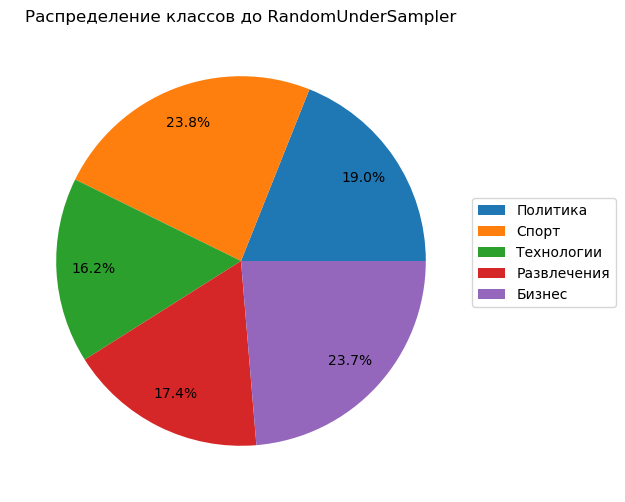

In [597]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [598]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

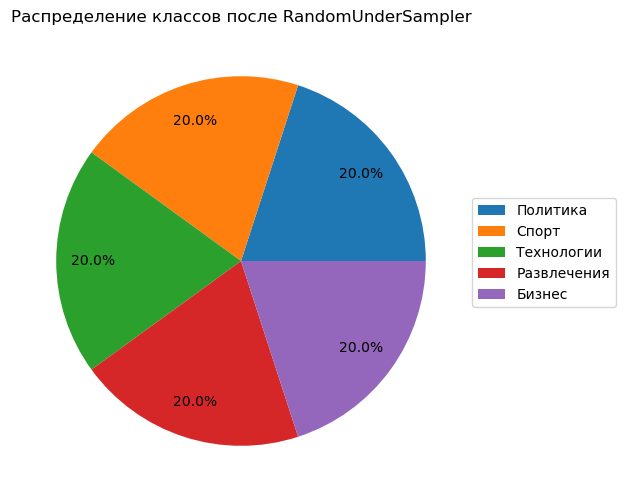

In [599]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [600]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [601]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [602]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [603]:
#######  Logistic Regression  #######
log_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=5)
log_grid_search.fit(X_train_scaled, y_train)
log_best_params = log_grid_search.best_params_

log = LogisticRegression(**log_best_params).fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf_param_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_params = rf_grid_search.best_params_

rf = RandomForestClassifier(**rf_best_params).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 4, 5],
                  'learning_rate': [0.1, 0.01, 0.001]}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid_search.best_params_

xgb = XGBClassifier(**xgb_best_params).fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm_param_grid = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'verbosity': [-1]}
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train_scaled, y_train)
lgbm_best_params = lgbm_grid_search.best_params_

lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
# CatBoost имеет встроенную настройку гиперпараметров, поэтому GridSearchCV не нужен
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
# Преобразование данных в тензоры float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры для поиска
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

net = NeuralNetClassifier(
    NeuralNetwork,
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    module__input_size=input_size,
    module__hidden_size=64,
    module__num_classes=num_classes,
    verbose=0
)

# Определение параметров для Grid Search
params = {
    'net__lr': [0.001, 0.01],
    'net__max_epochs': [50, 100],
    'net__module__hidden_size': [32, 64, 128],
}

# Pipeline и Grid Search
pipe = Pipeline([('net', net)])
gs = GridSearchCV(pipe, params, refit=True, cv=3, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
gs.fit(X_train_scaled.astype(np.float32), y_train.values)

# Лучшая модель
best_model = gs.best_estimator_.named_steps['net']

# Прогнозирование на тестовых данных
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    outputs = best_model.forward(X_test_scaled_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### Расчёт accuracy

In [604]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9613899613899614, 0.9536679536679536, 0.9478764478764479, 0.9517374517374517, 0.9517374517374517, 0.9613899613899614]


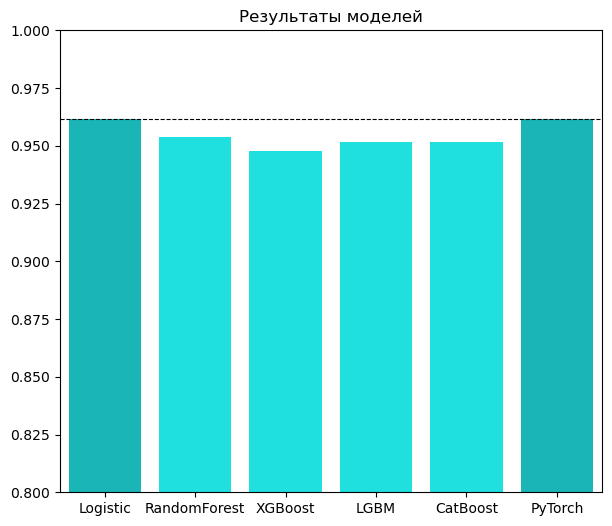

In [605]:
accuracy_list3 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list3)) else "darkturquoise" for i in accuracy_list3]
sns.barplot(x=np.arange(0,6), y=accuracy_list3, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list3)
plt.show()

In [606]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.94      0.97      0.95        95
           1       1.00      0.99      1.00       112
           2       0.98      0.96      0.97       101
           3       0.93      0.99      0.96       104
           4       0.96      0.90      0.93       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



In [607]:
# Вычисление классификационного отчета
class_report_pytorch = classification_report(y_test, y_pred_pytorch)

print("############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############\n")
print(class_report_pytorch)

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.98      1.00      0.99       112
           2       0.97      0.97      0.97       101
           3       0.98      0.96      0.97       104
           4       0.96      0.92      0.94       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самые важные факторы

In [608]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

feature_importance         features
0                 475       caps_count
1                 393      text_length
2                 305  stopwords_count
3                 278       word_count
4                 266              год

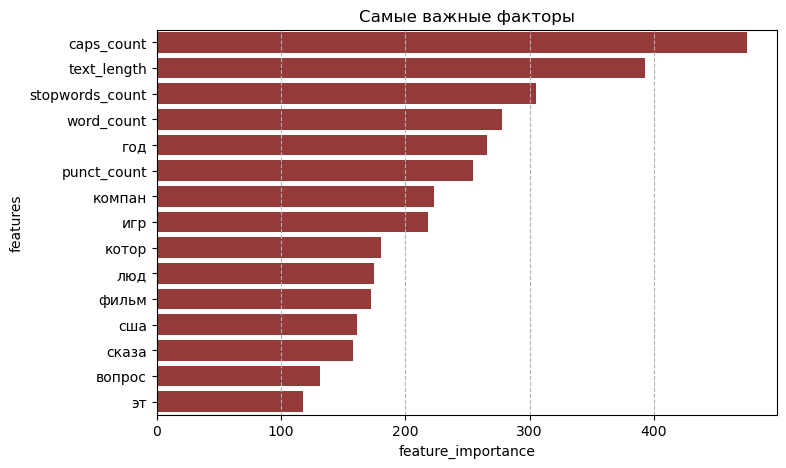

In [609]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самые важные факторы")
plt.grid(axis="x", ls="--")
plt.show()

### Очистка текста (4 метод - би-граммы)

In [610]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text4(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    n_grams = [' '.join(gram) for gram in ngrams(text, 2)]
    n_grams = " ".join(n_grams)
    return n_grams

df["cleaned_text"] = df["Text"].apply(clean_text4)

In [611]:
df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  
0  бюджет создания создания условий условий выбор...  
1  армейские вожди вожди составе составе полков п...  
2  говард отрицает отрицает разбивку разбивку удо...  
3  наблюдатели выборами выборами соединенном соед...  
4  килрой назвал назвал выборное выборное место м...

## Статистика по тексту

In [612]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  word_count  text_length  \
0  бюджет создания создания условий условий выбор...         684         5956   
1  армейские вожди вожди составе составе полков п...         574         5100   
2  говард отрицает отрицает разбивку разбивку удо...         660         5659   
3  наблюдатели выборами выборами соединенном соед...         678         6158   
4  килрой назвал назвал выборное выборное место м...         546         4536   

   stopwords_count  punct_count  caps_count  
0              108           86          57  
1              106           83          46  
2              123          109          63  
3              131           81          56  
4              106           96         109

In [613]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

word_count  text_length  stopwords_count  punct_count  caps_count
0  556.069479  4793.143921       111.652605    88.933002   60.119107
1  363.952475  2880.968317        82.200000    68.780198   63.982178
2  593.878261  5138.081159       113.455072    98.449275   72.304348
3  380.878049  3061.747967        72.604336    66.910569   67.260163
4  417.316103  3574.147117        72.391650    68.817097   55.952286

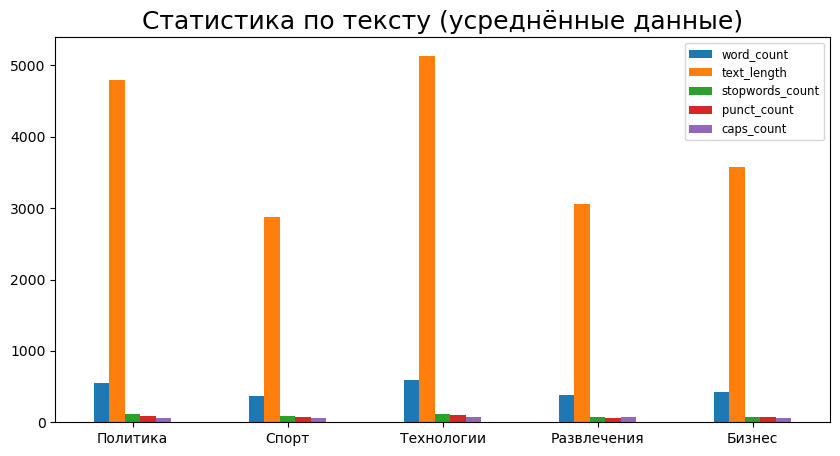

In [614]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

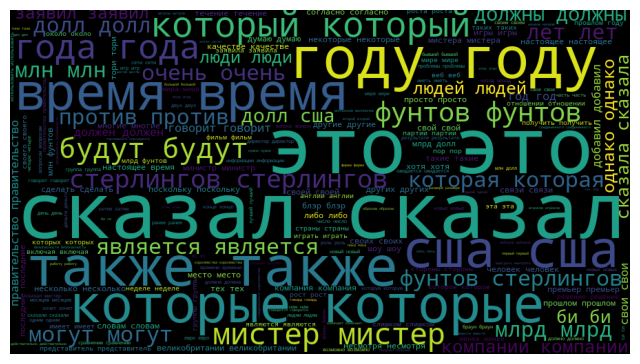

In [615]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [616]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

абсолютно  аварии  августа  августе  авиакомпании  авиакомпаний  \
0          0       0        0        0             0             0   
1          0       0        0        0             0             0   
2          0       0        0        0             0             0   
3          0       0        0        0             0             0   
4          0       0        0        0             0             0   

   авиакомпания  авиатор  австралии  австралийский  ...  ян  январе  января  \
0             0        0          0              0  ...   0       0       0   
1             0        0          0              0  ...   0       0       0   
2             0        0          0              0  ...   0       0       0   
3             0        0          0              0  ...   0       0       0   
4             0        0          0              0  ...   0       0       0   

   янг  японии  япония  японская  японский  ярдов  ясно  
0    0       0       0         0         0      0     0  
1    0       0       0         0         0      0     0  
2    0       0       0         0         0      0     0  
3    0       0       0         0         0      0     0  
4    0       0       0         0         0      0     2  

[5 rows x 5000 columns]

In [617]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count
0      0         684         5956              108           86          57
1      0         574         5100              106           83          46
2      0         660         5659              123          109          63
3      0         678         6158              131           81          56
4      0         546         4536              106           96         109

In [618]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0         684         5956              108           86          57   
1      0         574         5100              106           83          46   
2      0         660         5659              123          109          63   
3      0         678         6158              131           81          56   
4      0         546         4536              106           96         109   

   абсолютно  аварии  августа  августе  ...  ян  январе  января  янг  японии  \
0          0       0        0        0  ...   0       0       0    0       0   
1          0       0        0        0  ...   0       0       0    0       0   
2          0       0        0        0  ...   0       0       0    0       0   
3          0       0        0        0  ...   0       0       0    0       0   
4          0       0        0        0  ...   0       0       0    0       0   

   япония  японская  японский  ярдов  ясно  
0       0         0         0      0     0  
1       0         0         0      0     0  
2       0         0         0      0     0  
3       0         0         0      0     0  
4       0         0         0      0     2  

[5 rows x 5006 columns]

## RandomUnderSampler

In [619]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

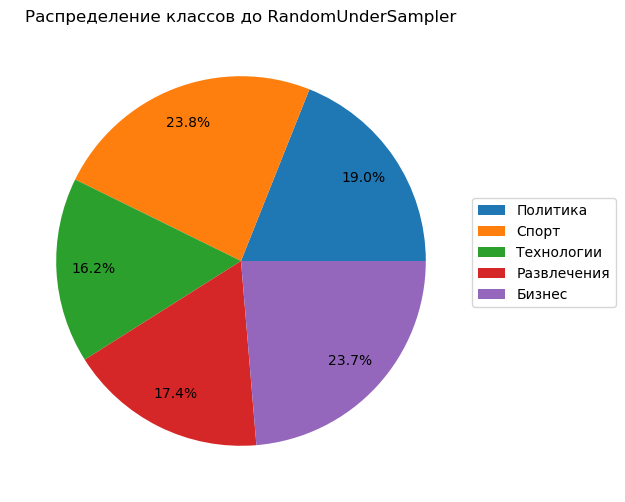

In [620]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [621]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

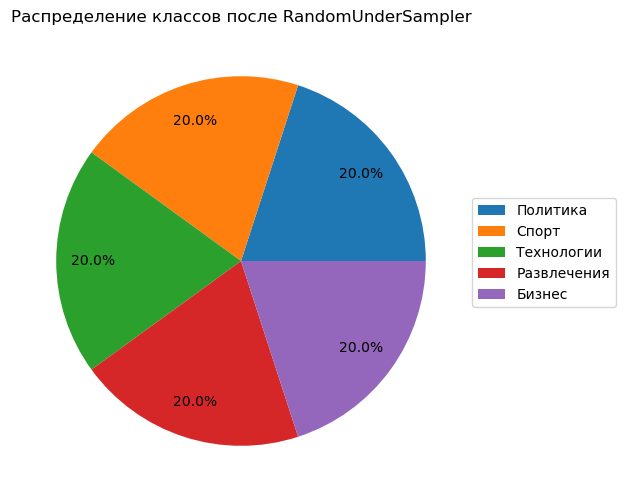

In [622]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [623]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [624]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [625]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [626]:
#######  Logistic Regression  #######
log_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=5)
log_grid_search.fit(X_train_scaled, y_train)
log_best_params = log_grid_search.best_params_

log = LogisticRegression(**log_best_params).fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf_param_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_params = rf_grid_search.best_params_

rf = RandomForestClassifier(**rf_best_params).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 4, 5],
                  'learning_rate': [0.1, 0.01, 0.001]}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid_search.best_params_

xgb = XGBClassifier(**xgb_best_params).fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm_param_grid = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'verbosity': [-1]}
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train_scaled, y_train)
lgbm_best_params = lgbm_grid_search.best_params_

lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
# CatBoost имеет встроенную настройку гиперпараметров, поэтому GridSearchCV не нужен
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
# Преобразование данных в тензоры float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры для поиска
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

net = NeuralNetClassifier(
    NeuralNetwork,
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    module__input_size=input_size,
    module__hidden_size=64,
    module__num_classes=num_classes,
    verbose=0
)

# Определение параметров для Grid Search
params = {
    'net__lr': [0.001, 0.01],
    'net__max_epochs': [50, 100],
    'net__module__hidden_size': [32, 64, 128],
}

# Pipeline и Grid Search
pipe = Pipeline([('net', net)])
gs = GridSearchCV(pipe, params, refit=True, cv=3, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
gs.fit(X_train_scaled.astype(np.float32), y_train.values)

# Лучшая модель
best_model = gs.best_estimator_.named_steps['net']

# Прогнозирование на тестовых данных
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    outputs = best_model.forward(X_test_scaled_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### Расчёт accuracy

In [627]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9633204633204633, 0.9343629343629344, 0.9343629343629344, 0.9401544401544402, 0.9478764478764479, 0.9575289575289575]


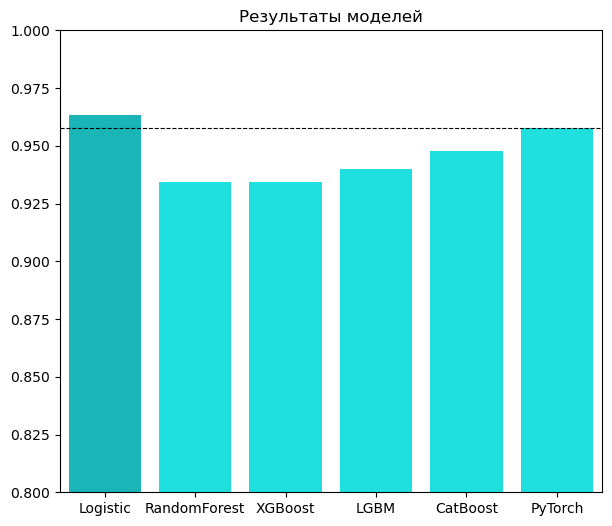

In [628]:
accuracy_list4 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list4)) else "darkturquoise" for i in accuracy_list4]
sns.barplot(x=np.arange(0,6), y=accuracy_list4, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list4)
plt.show()

In [629]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.97      0.97      0.97        95
           1       1.00      0.98      0.99       112
           2       0.96      0.96      0.96       101
           3       0.94      0.97      0.96       104
           4       0.94      0.93      0.94       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



In [630]:
# Вычисление классификационного отчета
class_report_pytorch = classification_report(y_test, y_pred_pytorch)

print("############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############\n")
print(class_report_pytorch)

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        95
           1       0.99      0.99      0.99       112
           2       0.94      0.97      0.96       101
           3       0.95      0.94      0.95       104
           4       0.96      0.92      0.94       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самые важные факторы

In [631]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

feature_importance         features
0                 493       caps_count
1                 416      text_length
2                 321  stopwords_count
3                 297       word_count
4                 264      punct_count

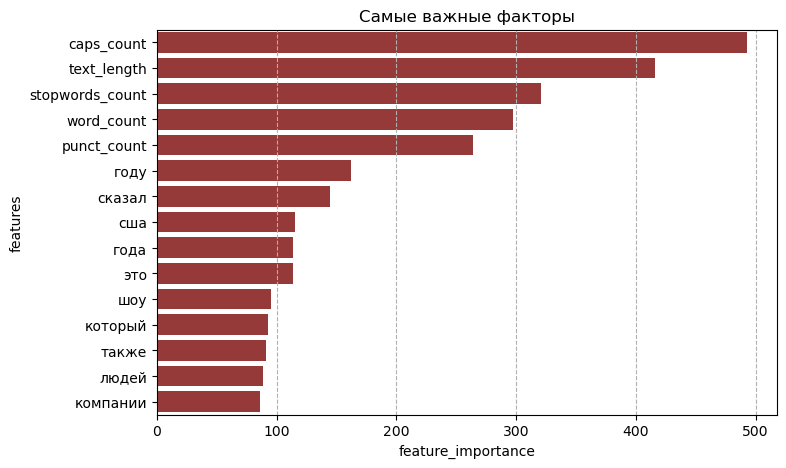

In [632]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самые важные факторы")
plt.grid(axis="x", ls="--")
plt.show()

### Очистка текста (5 метод - 3-граммы)

In [633]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text5(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    n_grams = [' '.join(gram) for gram in ngrams(text, 3)]
    n_grams = " ".join(n_grams)
    return n_grams

df["cleaned_text"] = df["Text"].apply(clean_text5)

In [634]:
df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  
0  бюджет создания условий создания условий выбор...  
1  армейские вожди составе вожди составе полков с...  
2  говард отрицает разбивку отрицает разбивку удо...  
3  наблюдатели выборами соединенном выборами соед...  
4  килрой назвал выборное назвал выборное место в...

## Статистика по тексту

In [635]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  word_count  text_length  \
0  бюджет создания условий создания условий выбор...        1023         8909   
1  армейские вожди составе вожди составе полков с...         858         7620   
2  говард отрицает разбивку отрицает разбивку удо...         987         8460   
3  наблюдатели выборами соединенном выборами соед...        1014         9208   
4  килрой назвал выборное назвал выборное место в...         816         6785   

   stopwords_count  punct_count  caps_count  
0              108           86          57  
1              106           83          46  
2              123          109          63  
3              131           81          56  
4              106           96         109

In [636]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

word_count  text_length  stopwords_count  punct_count  caps_count
0  831.104218  7163.761787       111.652605    88.933002   60.119107
1  542.928713  4297.566337        82.200000    68.780198   63.982178
2  887.817391  7681.678261       113.455072    98.449275   72.304348
3  568.317073  4569.132791        72.604336    66.910569   67.260163
4  622.974155  5336.073559        72.391650    68.817097   55.952286

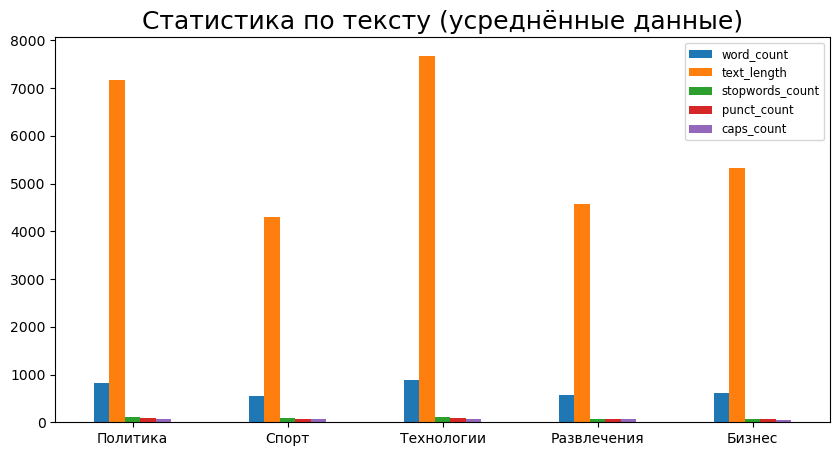

In [637]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

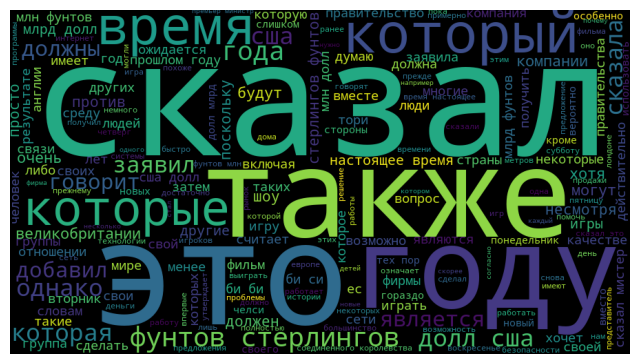

In [638]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [639]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

абсолютно  аварии  августа  августе  авиакомпании  авиакомпаний  \
0          0       0        0        0             0             0   
1          0       0        0        0             0             0   
2          0       0        0        0             0             0   
3          0       0        0        0             0             0   
4          0       0        0        0             0             0   

   авиакомпания  авиатор  австралии  австралийский  ...  ян  январе  января  \
0             0        0          0              0  ...   0       0       0   
1             0        0          0              0  ...   0       0       0   
2             0        0          0              0  ...   0       0       0   
3             0        0          0              0  ...   0       0       0   
4             0        0          0              0  ...   0       0       0   

   янг  японии  япония  японская  японский  ярдов  ясно  
0    0       0       0         0         0      0     0  
1    0       0       0         0         0      0     0  
2    0       0       0         0         0      0     0  
3    0       0       0         0         0      0     0  
4    0       0       0         0         0      0     3  

[5 rows x 5000 columns]

In [640]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count
0      0        1023         8909              108           86          57
1      0         858         7620              106           83          46
2      0         987         8460              123          109          63
3      0        1014         9208              131           81          56
4      0         816         6785              106           96         109

In [641]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0        1023         8909              108           86          57   
1      0         858         7620              106           83          46   
2      0         987         8460              123          109          63   
3      0        1014         9208              131           81          56   
4      0         816         6785              106           96         109   

   абсолютно  аварии  августа  августе  ...  ян  январе  января  янг  японии  \
0          0       0        0        0  ...   0       0       0    0       0   
1          0       0        0        0  ...   0       0       0    0       0   
2          0       0        0        0  ...   0       0       0    0       0   
3          0       0        0        0  ...   0       0       0    0       0   
4          0       0        0        0  ...   0       0       0    0       0   

   япония  японская  японский  ярдов  ясно  
0       0         0         0      0     0  
1       0         0         0      0     0  
2       0         0         0      0     0  
3       0         0         0      0     0  
4       0         0         0      0     3  

[5 rows x 5006 columns]

## RandomUnderSampler

In [642]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

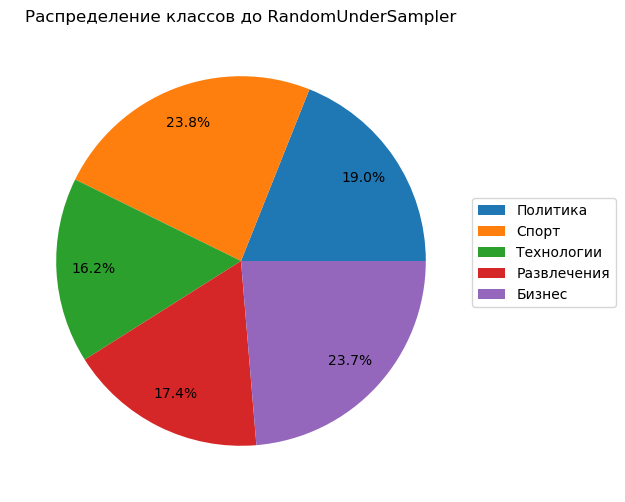

In [643]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [644]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

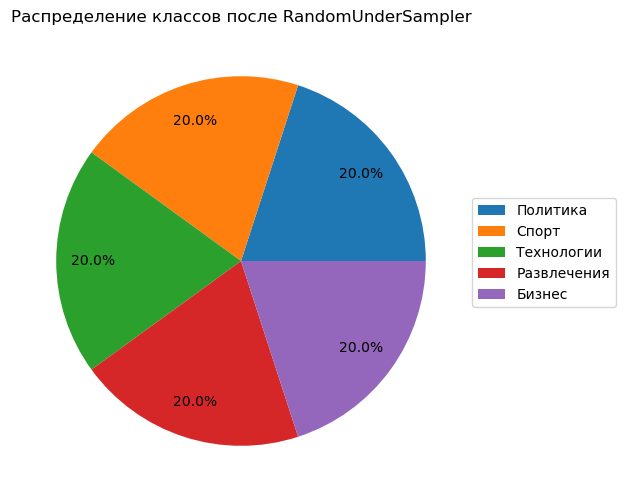

In [645]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [646]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [647]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [648]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [649]:
#######  Logistic Regression  #######
log_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=5)
log_grid_search.fit(X_train_scaled, y_train)
log_best_params = log_grid_search.best_params_

log = LogisticRegression(**log_best_params).fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf_param_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_params = rf_grid_search.best_params_

rf = RandomForestClassifier(**rf_best_params).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 4, 5],
                  'learning_rate': [0.1, 0.01, 0.001]}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid_search.best_params_

xgb = XGBClassifier(**xgb_best_params).fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm_param_grid = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'verbosity': [-1]}
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train_scaled, y_train)
lgbm_best_params = lgbm_grid_search.best_params_

lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
# CatBoost имеет встроенную настройку гиперпараметров, поэтому GridSearchCV не нужен
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
# Преобразование данных в тензоры float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры для поиска
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

net = NeuralNetClassifier(
    NeuralNetwork,
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    module__input_size=input_size,
    module__hidden_size=64,
    module__num_classes=num_classes,
    verbose=0
)

# Определение параметров для Grid Search
params = {
    'net__lr': [0.001, 0.01],
    'net__max_epochs': [50, 100],
    'net__module__hidden_size': [32, 64, 128],
}

# Pipeline и Grid Search
pipe = Pipeline([('net', net)])
gs = GridSearchCV(pipe, params, refit=True, cv=3, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
gs.fit(X_train_scaled.astype(np.float32), y_train.values)

# Лучшая модель
best_model = gs.best_estimator_.named_steps['net']

# Прогнозирование на тестовых данных
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    outputs = best_model.forward(X_test_scaled_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### Расчёт accuracy

In [650]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9613899613899614, 0.9362934362934363, 0.9324324324324325, 0.9382239382239382, 0.9420849420849421, 0.9575289575289575]


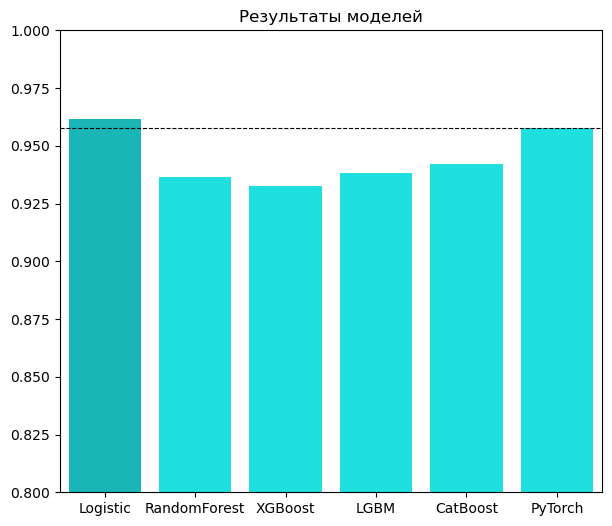

In [651]:
accuracy_list5 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list5)) else "darkturquoise" for i in accuracy_list5]
sns.barplot(x=np.arange(0,6), y=accuracy_list5, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list5)
plt.show()

In [652]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.96      0.97      0.96        95
           1       1.00      0.99      1.00       112
           2       0.97      0.95      0.96       101
           3       0.94      0.96      0.95       104
           4       0.93      0.93      0.93       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



In [653]:
# Вычисление классификационного отчета
class_report_pytorch = classification_report(y_test, y_pred_pytorch)

print("############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############\n")
print(class_report_pytorch)

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############

              precision    recall  f1-score   support

           0       0.93      0.98      0.95        95
           1       0.98      0.99      0.99       112
           2       0.93      0.98      0.96       101
           3       0.98      0.93      0.96       104
           4       0.96      0.91      0.93       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самые важные факторы

In [654]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

feature_importance         features
0                 716       caps_count
1                 546      text_length
2                 485  stopwords_count
3                 402      punct_count
4                 371       word_count

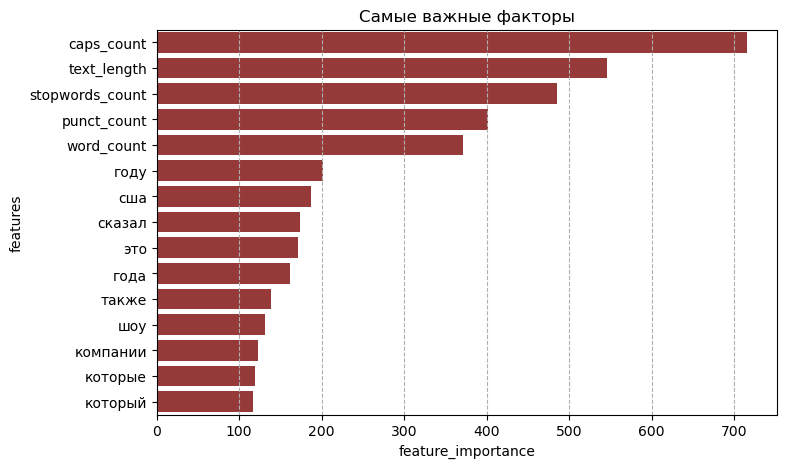

In [655]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самые важные факторы")
plt.grid(axis="x", ls="--")
plt.show()

### Очистка текста (6 метод - 4-граммы)

In [656]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text6(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    n_grams = [' '.join(gram) for gram in ngrams(text, 4)]
    n_grams = " ".join(n_grams)
    return n_grams

df["cleaned_text"] = df["Text"].apply(clean_text6)

In [657]:
df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  
0  бюджет создания условий выборов создания услов...  
1  армейские вожди составе полков вожди составе п...  
2  говард отрицает разбивку удостоверения отрицае...  
3  наблюдатели выборами соединенном королевстве в...  
4  килрой назвал выборное место назвал выборное м...

## Статистика по тексту

In [658]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  word_count  text_length  \
0  бюджет создания условий выборов создания услов...        1360        11848   
1  армейские вожди составе полков вожди составе п...        1140        10126   
2  говард отрицает разбивку удостоверения отрицае...        1312        11237   
3  наблюдатели выборами соединенном королевстве в...        1348        12237   
4  килрой назвал выборное место назвал выборное м...        1084         9017   

   stopwords_count  punct_count  caps_count  
0              108           86          57  
1              106           83          46  
2              123          109          63  
3              131           81          56  
4              106           96         109

In [659]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

word_count   text_length  stopwords_count  punct_count  caps_count
0  1104.138958   9516.662531       111.652605    88.933002   60.119107
1   719.904950   5697.936634        82.200000    68.780198   63.982178
2  1179.756522  10207.910145       113.455072    98.449275   72.304348
3   753.756098   6059.978320        72.604336    66.910569   67.260163
4   826.632207   7080.751491        72.391650    68.817097   55.952286

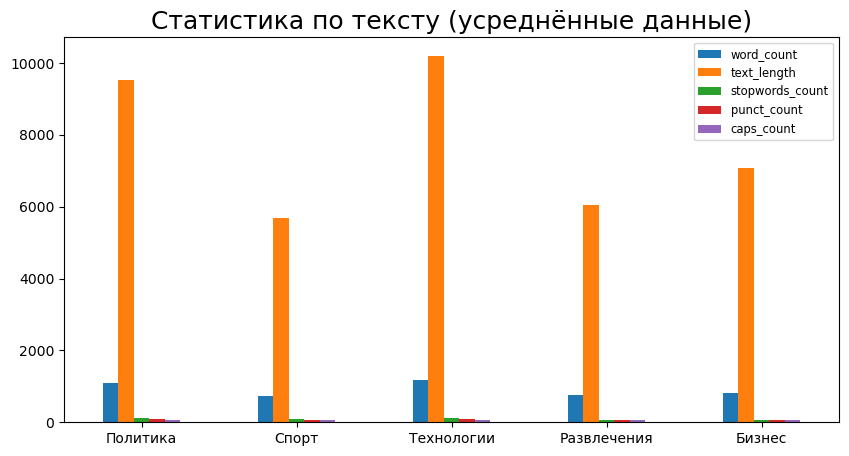

In [660]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

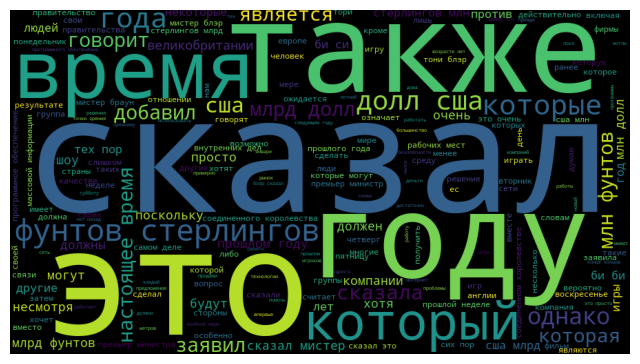

In [661]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [662]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

абсолютно  аварии  августа  августе  авиакомпании  авиакомпаний  \
0          0       0        0        0             0             0   
1          0       0        0        0             0             0   
2          0       0        0        0             0             0   
3          0       0        0        0             0             0   
4          0       0        0        0             0             0   

   авиакомпания  авиатор  австралии  австралийский  ...  ян  январе  января  \
0             0        0          0              0  ...   0       0       0   
1             0        0          0              0  ...   0       0       0   
2             0        0          0              0  ...   0       0       0   
3             0        0          0              0  ...   0       0       0   
4             0        0          0              0  ...   0       0       0   

   янг  японии  япония  японская  японский  ярдов  ясно  
0    0       0       0         0         0      0     0  
1    0       0       0         0         0      0     0  
2    0       0       0         0         0      0     0  
3    0       0       0         0         0      0     0  
4    0       0       0         0         0      0     4  

[5 rows x 5000 columns]

In [663]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count
0      0        1360        11848              108           86          57
1      0        1140        10126              106           83          46
2      0        1312        11237              123          109          63
3      0        1348        12237              131           81          56
4      0        1084         9017              106           96         109

In [664]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0        1360        11848              108           86          57   
1      0        1140        10126              106           83          46   
2      0        1312        11237              123          109          63   
3      0        1348        12237              131           81          56   
4      0        1084         9017              106           96         109   

   абсолютно  аварии  августа  августе  ...  ян  январе  января  янг  японии  \
0          0       0        0        0  ...   0       0       0    0       0   
1          0       0        0        0  ...   0       0       0    0       0   
2          0       0        0        0  ...   0       0       0    0       0   
3          0       0        0        0  ...   0       0       0    0       0   
4          0       0        0        0  ...   0       0       0    0       0   

   япония  японская  японский  ярдов  ясно  
0       0         0         0      0     0  
1       0         0         0      0     0  
2       0         0         0      0     0  
3       0         0         0      0     0  
4       0         0         0      0     4  

[5 rows x 5006 columns]

## RandomUnderSampler

In [665]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

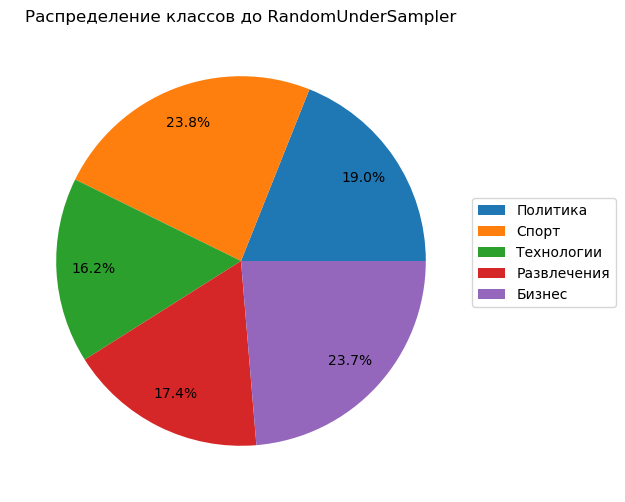

In [666]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [667]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

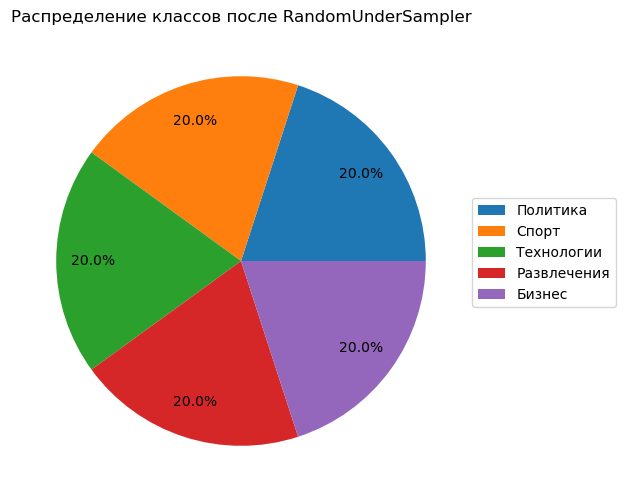

In [668]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [669]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [670]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [671]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [672]:
#######  Logistic Regression  #######
log_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=5)
log_grid_search.fit(X_train_scaled, y_train)
log_best_params = log_grid_search.best_params_

log = LogisticRegression(**log_best_params).fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf_param_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_params = rf_grid_search.best_params_

rf = RandomForestClassifier(**rf_best_params).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 4, 5],
                  'learning_rate': [0.1, 0.01, 0.001]}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid_search.best_params_

xgb = XGBClassifier(**xgb_best_params).fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm_param_grid = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'verbosity': [-1]}
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train_scaled, y_train)
lgbm_best_params = lgbm_grid_search.best_params_

lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
# CatBoost имеет встроенную настройку гиперпараметров, поэтому GridSearchCV не нужен
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
# Преобразование данных в тензоры float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры для поиска
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

net = NeuralNetClassifier(
    NeuralNetwork,
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    module__input_size=input_size,
    module__hidden_size=64,
    module__num_classes=num_classes,
    verbose=0
)

# Определение параметров для Grid Search
params = {
    'net__lr': [0.001, 0.01],
    'net__max_epochs': [50, 100],
    'net__module__hidden_size': [32, 64, 128],
}

# Pipeline и Grid Search
pipe = Pipeline([('net', net)])
gs = GridSearchCV(pipe, params, refit=True, cv=3, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
gs.fit(X_train_scaled.astype(np.float32), y_train.values)

# Лучшая модель
best_model = gs.best_estimator_.named_steps['net']

# Прогнозирование на тестовых данных
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    outputs = best_model.forward(X_test_scaled_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### Расчёт accuracy

In [673]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9613899613899614, 0.9343629343629344, 0.9227799227799228, 0.9420849420849421, 0.9459459459459459, 0.9613899613899614]


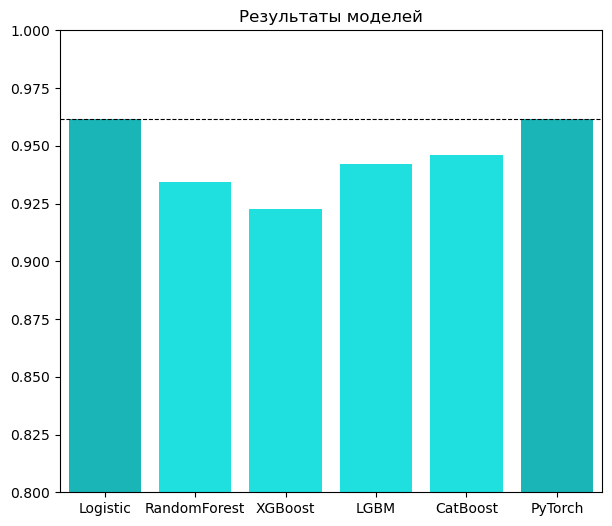

In [674]:
accuracy_list6 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list6)) else "darkturquoise" for i in accuracy_list6]
sns.barplot(x=np.arange(0,6), y=accuracy_list6, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list6)
plt.show()

In [675]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.96      0.97      0.96        95
           1       1.00      0.98      0.99       112
           2       0.95      0.95      0.95       101
           3       0.94      0.97      0.96       104
           4       0.95      0.93      0.94       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



In [676]:
# Вычисление классификационного отчета
class_report_pytorch = classification_report(y_test, y_pred_pytorch)

print("############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############\n")
print(class_report_pytorch)

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        95
           1       1.00      0.98      0.99       112
           2       0.96      0.96      0.96       101
           3       0.93      0.96      0.95       104
           4       0.95      0.92      0.94       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самые важные факторы

In [677]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

feature_importance         features
0                 713       caps_count
1                 532      text_length
2                 472  stopwords_count
3                 377      punct_count
4                 374       word_count

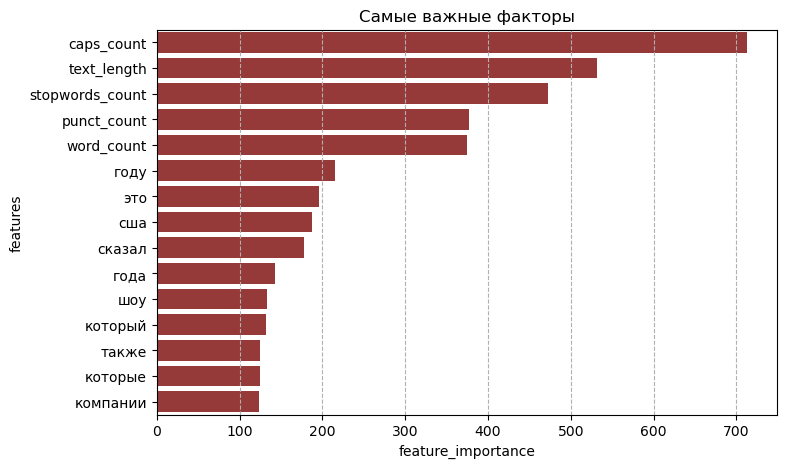

In [678]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самые важные факторы")
plt.grid(axis="x", ls="--")
plt.show()

## Очистка текста (7 метод - лемматизация + би-граммы)

In [679]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text7(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    mystem = Mystem()
    text = [mystem.lemmatize(word)[0] for word in text]
    n_grams = [' '.join(gram) for gram in ngrams(text, 2)]
    n_grams = " ".join(n_grams)
    return n_grams

df["cleaned_text"] = df["Text"].apply(clean_text7)

In [680]:
df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  
0  бюджет создание создание условие условие выбор...  
1  армейский вождь вождь состав состав полк полк ...  
2  говард отрицать отрицать разбивка разбивка удо...  
3  наблюдатель выборы выборы соединять соединять ...  
4  килрой называть называть выборный выборный мес...

## Статистика по тексту

In [681]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  word_count  text_length  \
0  бюджет создание создание условие условие выбор...         684         5846   
1  армейский вождь вождь состав состав полк полк ...         574         5024   
2  говард отрицать отрицать разбивка разбивка удо...         660         5720   
3  наблюдатель выборы выборы соединять соединять ...         678         6009   
4  килрой называть называть выборный выборный мес...         546         4526   

   stopwords_count  punct_count  caps_count  
0              108           86          57  
1              106           83          46  
2              123          109          63  
3              131           81          56  
4              106           96         109

In [682]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

word_count  text_length  stopwords_count  punct_count  caps_count
0  556.069479  4745.739454       111.652605    88.933002   60.119107
1  363.952475  2879.168317        82.200000    68.780198   63.982178
2  593.878261  5071.292754       113.455072    98.449275   72.304348
3  380.878049  3033.997290        72.604336    66.910569   67.260163
4  417.316103  3522.769384        72.391650    68.817097   55.952286

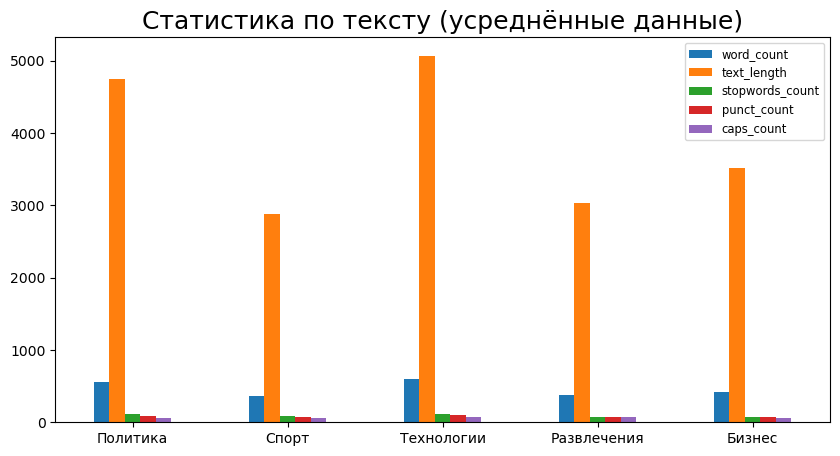

In [683]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

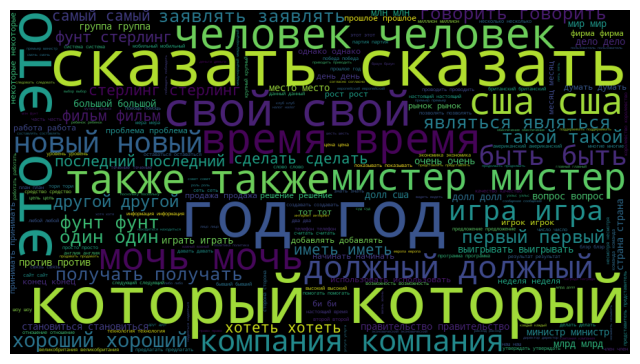

In [684]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [685]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

аборт  абсолютно  абсолютный  авария  август  авиакомпания  авиатор  \
0      0          0           0       0       0             0        0   
1      0          0           0       0       0             0        0   
2      0          0           0       0       0             0        0   
3      0          0           0       0       0             0        0   
4      0          0           0       0       0             0        0   

   авиация  авива  австралийский  ...  ярд  яркий  ярлык  ярмарка  ясно  \
0        0      0              0  ...    0      0      0        0     0   
1        0      0              0  ...    0      0      0        0     0   
2        0      0              0  ...    0      0      0        0     0   
3        0      0              0  ...    0      0      0        0     0   
4        0      0              0  ...    0      0      0        0     2   

   ясный  яху  ячвили  ячейка  ящик  
0      0    0       0       0     0  
1      0    0       0       0     0  
2      0    0       0       0     0  
3      0    0       0       0     0  
4      0    0       0       0     0  

[5 rows x 5000 columns]

In [686]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count
0      0         684         5846              108           86          57
1      0         574         5024              106           83          46
2      0         660         5720              123          109          63
3      0         678         6009              131           81          56
4      0         546         4526              106           96         109

In [687]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0         684         5846              108           86          57   
1      0         574         5024              106           83          46   
2      0         660         5720              123          109          63   
3      0         678         6009              131           81          56   
4      0         546         4526              106           96         109   

   аборт  абсолютно  абсолютный  авария  ...  ярд  яркий  ярлык  ярмарка  \
0      0          0           0       0  ...    0      0      0        0   
1      0          0           0       0  ...    0      0      0        0   
2      0          0           0       0  ...    0      0      0        0   
3      0          0           0       0  ...    0      0      0        0   
4      0          0           0       0  ...    0      0      0        0   

   ясно  ясный  яху  ячвили  ячейка  ящик  
0     0      0    0       0       0     0  
1     0      0    0       0       0     0  
2     0      0    0       0       0     0  
3     0      0    0       0       0     0  
4     2      0    0       0       0     0  

[5 rows x 5006 columns]

## RandomUnderSampler

In [688]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

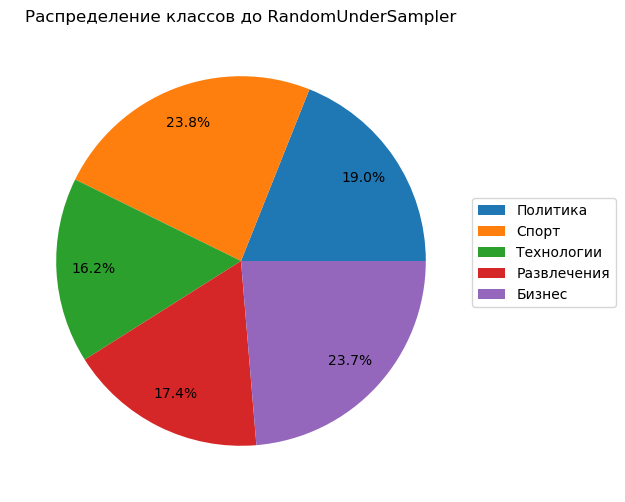

In [689]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [690]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

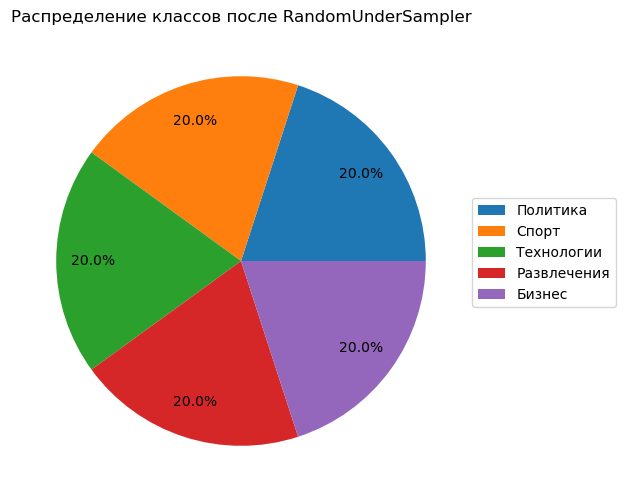

In [691]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [692]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [693]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [694]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [695]:
#######  Logistic Regression  #######
log_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=5)
log_grid_search.fit(X_train_scaled, y_train)
log_best_params = log_grid_search.best_params_

log = LogisticRegression(**log_best_params).fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf_param_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_params = rf_grid_search.best_params_

rf = RandomForestClassifier(**rf_best_params).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 4, 5],
                  'learning_rate': [0.1, 0.01, 0.001]}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid_search.best_params_

xgb = XGBClassifier(**xgb_best_params).fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm_param_grid = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'verbosity': [-1]}
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train_scaled, y_train)
lgbm_best_params = lgbm_grid_search.best_params_

lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
# CatBoost имеет встроенную настройку гиперпараметров, поэтому GridSearchCV не нужен
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
# Преобразование данных в тензоры float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры для поиска
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

net = NeuralNetClassifier(
    NeuralNetwork,
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    module__input_size=input_size,
    module__hidden_size=64,
    module__num_classes=num_classes,
    verbose=0
)

# Определение параметров для Grid Search
params = {
    'net__lr': [0.001, 0.01],
    'net__max_epochs': [50, 100],
    'net__module__hidden_size': [32, 64, 128],
}

# Pipeline и Grid Search
pipe = Pipeline([('net', net)])
gs = GridSearchCV(pipe, params, refit=True, cv=3, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
gs.fit(X_train_scaled.astype(np.float32), y_train.values)

# Лучшая модель
best_model = gs.best_estimator_.named_steps['net']

# Прогнозирование на тестовых данных
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    outputs = best_model.forward(X_test_scaled_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### Расчёт accuracy

In [696]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9536679536679536, 0.9420849420849421, 0.9382239382239382, 0.9478764478764479, 0.9478764478764479, 0.9652509652509652]


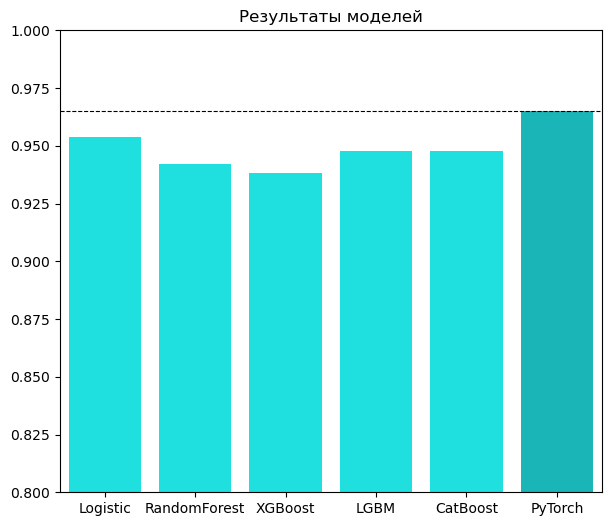

In [697]:
accuracy_list7 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list7)) else "darkturquoise" for i in accuracy_list7]
sns.barplot(x=np.arange(0,6), y=accuracy_list7, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list7)
plt.show()

In [698]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.95      0.95      0.95        95
           1       0.98      1.00      0.99       112
           2       0.97      0.94      0.95       101
           3       0.93      0.98      0.95       104
           4       0.94      0.90      0.92       106

    accuracy                           0.95       518
   macro avg       0.95      0.95      0.95       518
weighted avg       0.95      0.95      0.95       518



In [699]:
# Вычисление классификационного отчета
class_report_pytorch = classification_report(y_test, y_pred_pytorch)

print("############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############\n")
print(class_report_pytorch)

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        95
           1       0.99      1.00      1.00       112
           2       0.97      0.97      0.97       101
           3       0.97      0.98      0.98       104
           4       0.95      0.92      0.93       106

    accuracy                           0.97       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.97      0.97      0.97       518



## Самые важные факторы

In [700]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

feature_importance         features
0                 259       caps_count
1                 234      text_length
2                 199              год
3                 181       word_count
4                 156  stopwords_count

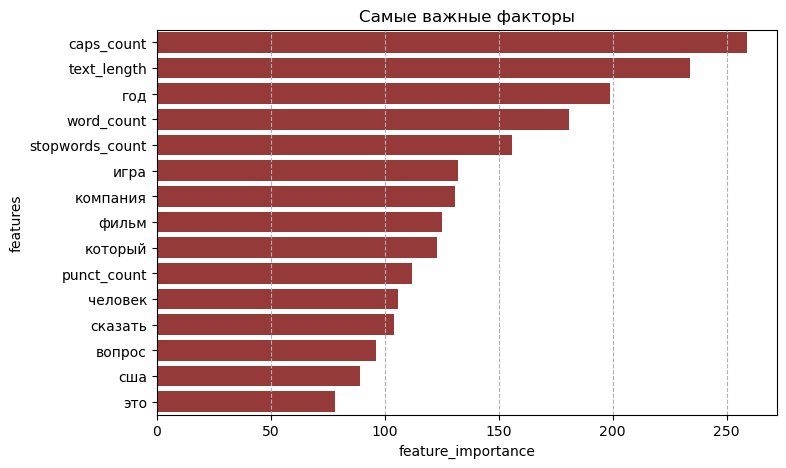

In [701]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самые важные факторы")
plt.grid(axis="x", ls="--")
plt.show()

### Очистка текста (8 метод - стемминг + би-граммы)

In [702]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text8(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    stemmer = snowballstemmer.stemmer('russian')
    text = [stemmer.stemWord(word) for word in text]    
    n_grams = [' '.join(gram) for gram in ngrams(text, 2)]
    n_grams = " ".join(n_grams)
    return n_grams

df["cleaned_text"] = df["Text"].apply(clean_text8)

In [703]:
df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  
0  бюджет создан создан услов услов выбор выбор г...  
1  армейск вожд вожд состав состав полк полк ожид...  
2  говард отрица отрица разбивк разбивк удостовер...  
3  наблюдател выбор выбор соединен соединен корол...  
4  килр назва назва выборн выборн мест мест бывш ...

## Статистика по тексту

In [704]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  word_count  text_length  \
0  бюджет создан создан услов услов выбор выбор г...         684         4860   
1  армейск вожд вожд состав состав полк полк ожид...         574         4120   
2  говард отрица отрица разбивк разбивк удостовер...         660         4640   
3  наблюдател выбор выбор соединен соединен корол...         678         4992   
4  килр назва назва выборн выборн мест мест бывш ...         546         3687   

   stopwords_count  punct_count  caps_count  
0              108           86          57  
1              106           83          46  
2              123          109          63  
3              131           81          56  
4              106           96         109

In [705]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

word_count  text_length  stopwords_count  punct_count  caps_count
0  556.069479  3893.161290       111.652605    88.933002   60.119107
1  363.952475  2348.796040        82.200000    68.780198   63.982178
2  593.878261  4136.211594       113.455072    98.449275   72.304348
3  380.878049  2495.693767        72.604336    66.910569   67.260163
4  417.316103  2898.031809        72.391650    68.817097   55.952286

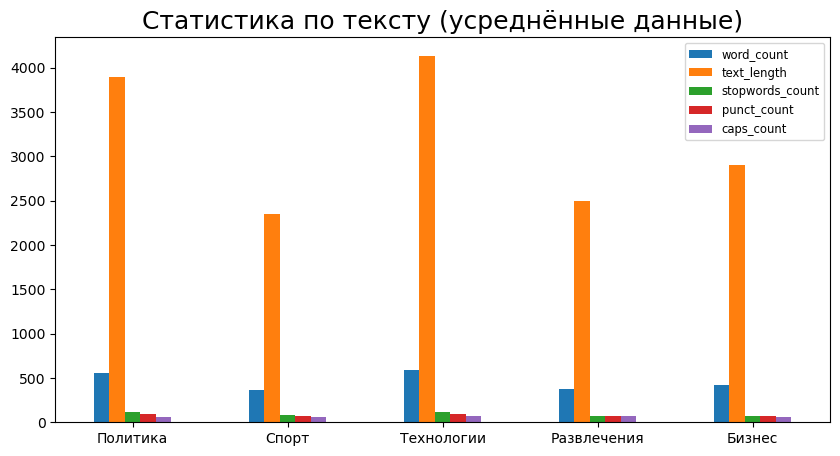

In [706]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

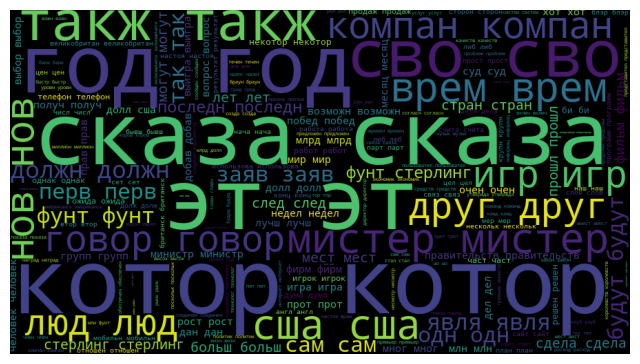

In [707]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [708]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

аббас  аборт  абсолютн  авар  август  авиакомпан  авиатор  авиац  авив  \
0      0      0         0     0       0           0        0      0     0   
1      0      0         0     0       0           0        0      0     0   
2      0      0         0     0       0           0        0      0     0   
3      0      0         0     0       0           0        0      0     0   
4      0      0         0     0       0           0        0      0     0   

   австр  ...  японск  ярд  ярк  ярлык  ярмарк  ясн  ях  ячв  ячейк  ящик  
0      0  ...       0    0    0      0       0    0   0    0      0     0  
1      0  ...       0    0    0      0       0    0   0    0      0     0  
2      0  ...       0    0    0      0       0    0   0    0      0     0  
3      0  ...       0    0    0      0       0    0   0    0      0     0  
4      0  ...       0    0    0      0       0    2   0    0      0     0  

[5 rows x 5000 columns]

In [709]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count
0      0         684         4860              108           86          57
1      0         574         4120              106           83          46
2      0         660         4640              123          109          63
3      0         678         4992              131           81          56
4      0         546         3687              106           96         109

In [710]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0         684         4860              108           86          57   
1      0         574         4120              106           83          46   
2      0         660         4640              123          109          63   
3      0         678         4992              131           81          56   
4      0         546         3687              106           96         109   

   аббас  аборт  абсолютн  авар  ...  японск  ярд  ярк  ярлык  ярмарк  ясн  \
0      0      0         0     0  ...       0    0    0      0       0    0   
1      0      0         0     0  ...       0    0    0      0       0    0   
2      0      0         0     0  ...       0    0    0      0       0    0   
3      0      0         0     0  ...       0    0    0      0       0    0   
4      0      0         0     0  ...       0    0    0      0       0    2   

   ях  ячв  ячейк  ящик  
0   0    0      0     0  
1   0    0      0     0  
2   0    0      0     0  
3   0    0      0     0  
4   0    0      0     0  

[5 rows x 5006 columns]

## RandomUnderSampler

In [711]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

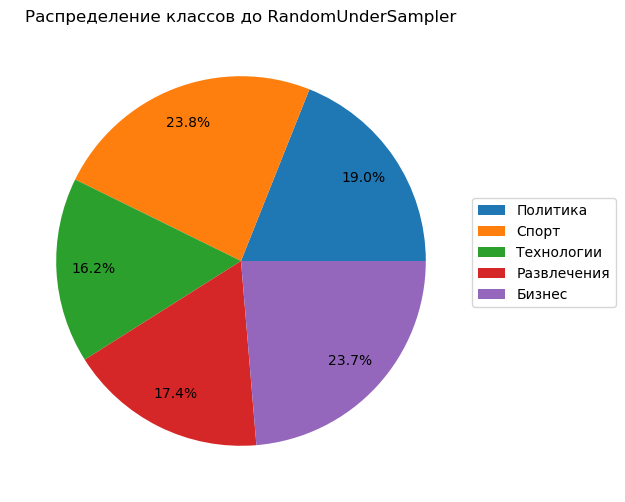

In [712]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [713]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

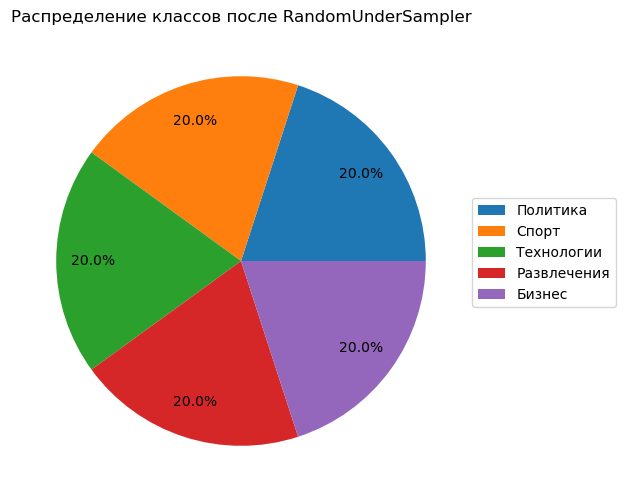

In [714]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [715]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [716]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [717]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [718]:
#######  Logistic Regression  #######
log_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=5)
log_grid_search.fit(X_train_scaled, y_train)
log_best_params = log_grid_search.best_params_

log = LogisticRegression(**log_best_params).fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf_param_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_params = rf_grid_search.best_params_

rf = RandomForestClassifier(**rf_best_params).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 4, 5],
                  'learning_rate': [0.1, 0.01, 0.001]}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid_search.best_params_

xgb = XGBClassifier(**xgb_best_params).fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm_param_grid = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'verbosity': [-1]}
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train_scaled, y_train)
lgbm_best_params = lgbm_grid_search.best_params_

lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
# CatBoost имеет встроенную настройку гиперпараметров, поэтому GridSearchCV не нужен
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
# Преобразование данных в тензоры float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры для поиска
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

net = NeuralNetClassifier(
    NeuralNetwork,
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    module__input_size=input_size,
    module__hidden_size=64,
    module__num_classes=num_classes,
    verbose=0
)

# Определение параметров для Grid Search
params = {
    'net__lr': [0.001, 0.01],
    'net__max_epochs': [50, 100],
    'net__module__hidden_size': [32, 64, 128],
}

# Pipeline и Grid Search
pipe = Pipeline([('net', net)])
gs = GridSearchCV(pipe, params, refit=True, cv=3, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
gs.fit(X_train_scaled.astype(np.float32), y_train.values)

# Лучшая модель
best_model = gs.best_estimator_.named_steps['net']

# Прогнозирование на тестовых данных
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    outputs = best_model.forward(X_test_scaled_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### Расчёт accuracy

In [719]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9633204633204633, 0.9498069498069498, 0.9498069498069498, 0.9459459459459459, 0.9555984555984556, 0.9652509652509652]


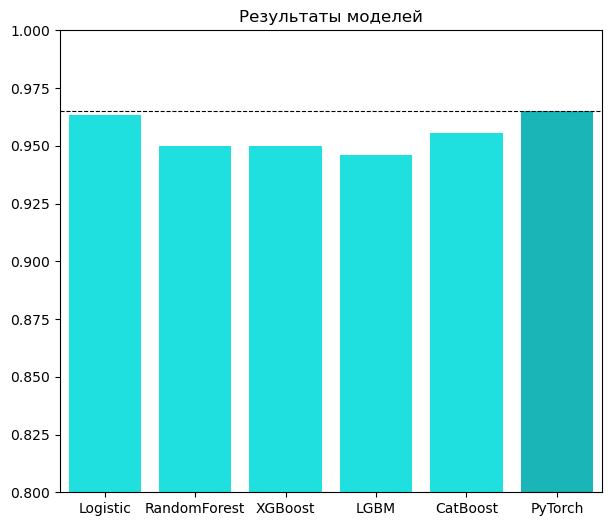

In [720]:
accuracy_list8 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list8)) else "darkturquoise" for i in accuracy_list8]
sns.barplot(x=np.arange(0,6), y=accuracy_list8, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list8)
plt.show()

In [721]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.94      0.97      0.95        95
           1       1.00      0.99      1.00       112
           2       0.97      0.95      0.96       101
           3       0.95      0.99      0.97       104
           4       0.95      0.92      0.93       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



In [722]:
# Вычисление классификационного отчета
class_report_pytorch = classification_report(y_test, y_pred_pytorch)

print("############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############\n")
print(class_report_pytorch)

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        95
           1       0.99      1.00      1.00       112
           2       0.97      0.96      0.97       101
           3       0.96      0.97      0.97       104
           4       0.96      0.92      0.94       106

    accuracy                           0.97       518
   macro avg       0.96      0.97      0.96       518
weighted avg       0.97      0.97      0.97       518



## Самые важные факторы

In [723]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

feature_importance         features
0                 173      text_length
1                 166       caps_count
2                 150              год
3                 120  stopwords_count
4                 118       word_count

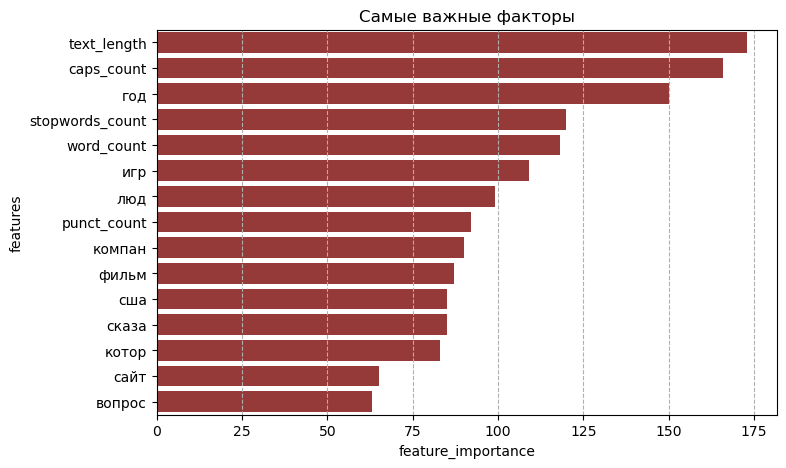

In [724]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самые важные факторы")
plt.grid(axis="x", ls="--")
plt.show()

## Очистка текста (9 метод - лемматизация + 4-граммы)

In [725]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text9(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    mystem = Mystem()
    text = [mystem.lemmatize(word)[0] for word in text]
    n_grams = [' '.join(gram) for gram in ngrams(text, 4)]
    n_grams = " ".join(n_grams)
    return n_grams

df["cleaned_text"] = df["Text"].apply(clean_text9)

In [726]:
df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  
0  бюджет создание условие выбор создание условие...  
1  армейский вождь состав полк вождь состав полк ...  
2  говард отрицать разбивка удостоверение отрицат...  
3  наблюдатель выборы соединять королевство выбор...  
4  килрой называть выборный место называть выборн...

## Статистика по тексту

In [727]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  word_count  text_length  \
0  бюджет создание условие выбор создание условие...        1360        11633   
1  армейский вождь состав полк вождь состав полк ...        1140         9975   
2  говард отрицать разбивка удостоверение отрицат...        1312        11356   
3  наблюдатель выборы соединять королевство выбор...        1348        11946   
4  килрой называть выборный место называть выборн...        1084         8991   

   stopwords_count  punct_count  caps_count  
0              108           86          57  
1              106           83          46  
2              123          109          63  
3              131           81          56  
4              106           96         109

In [728]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

word_count   text_length  stopwords_count  punct_count  caps_count
0  1104.138958   9422.513648       111.652605    88.933002   60.119107
1   719.904950   5694.156436        82.200000    68.780198   63.982178
2  1179.756522  10075.214493       113.455072    98.449275   72.304348
3   753.756098   6005.130081        72.604336    66.910569   67.260163
4   826.632207   6978.996024        72.391650    68.817097   55.952286

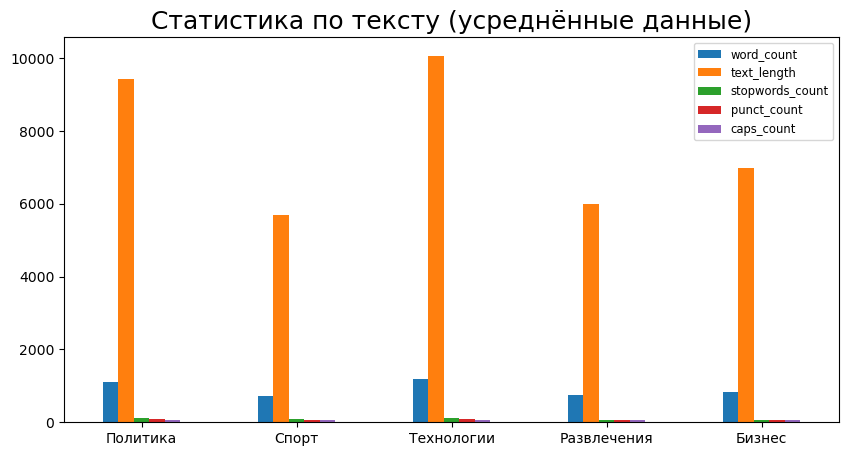

In [729]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

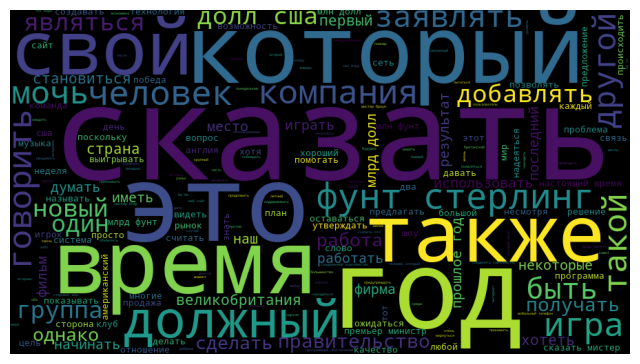

In [730]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [731]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

аборт  абсолютно  абсолютный  авария  август  авиакомпания  авиатор  \
0      0          0           0       0       0             0        0   
1      0          0           0       0       0             0        0   
2      0          0           0       0       0             0        0   
3      0          0           0       0       0             0        0   
4      0          0           0       0       0             0        0   

   авиация  авива  австралийский  ...  ярд  яркий  ярлык  ярмарка  ясно  \
0        0      0              0  ...    0      0      0        0     0   
1        0      0              0  ...    0      0      0        0     0   
2        0      0              0  ...    0      0      0        0     0   
3        0      0              0  ...    0      0      0        0     0   
4        0      0              0  ...    0      0      0        0     4   

   ясный  яху  ячвили  ячейка  ящик  
0      0    0       0       0     0  
1      0    0       0       0     0  
2      0    0       0       0     0  
3      0    0       0       0     0  
4      0    0       0       0     0  

[5 rows x 5000 columns]

In [732]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count
0      0        1360        11633              108           86          57
1      0        1140         9975              106           83          46
2      0        1312        11356              123          109          63
3      0        1348        11946              131           81          56
4      0        1084         8991              106           96         109

In [733]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0        1360        11633              108           86          57   
1      0        1140         9975              106           83          46   
2      0        1312        11356              123          109          63   
3      0        1348        11946              131           81          56   
4      0        1084         8991              106           96         109   

   аборт  абсолютно  абсолютный  авария  ...  ярд  яркий  ярлык  ярмарка  \
0      0          0           0       0  ...    0      0      0        0   
1      0          0           0       0  ...    0      0      0        0   
2      0          0           0       0  ...    0      0      0        0   
3      0          0           0       0  ...    0      0      0        0   
4      0          0           0       0  ...    0      0      0        0   

   ясно  ясный  яху  ячвили  ячейка  ящик  
0     0      0    0       0       0     0  
1     0      0    0       0       0     0  
2     0      0    0       0       0     0  
3     0      0    0       0       0     0  
4     4      0    0       0       0     0  

[5 rows x 5006 columns]

## RandomUnderSampler

In [734]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

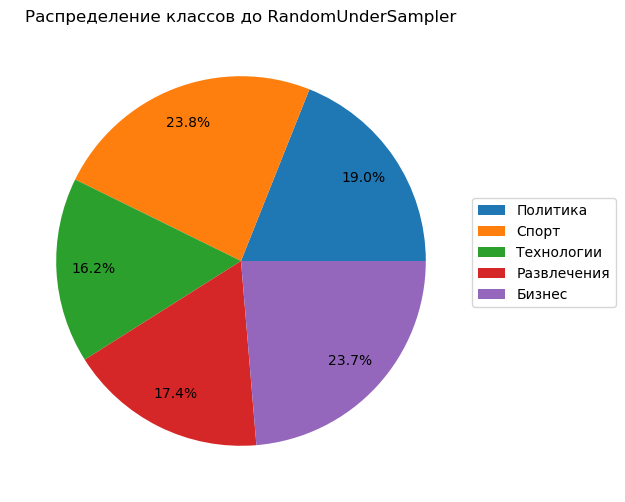

In [735]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [736]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

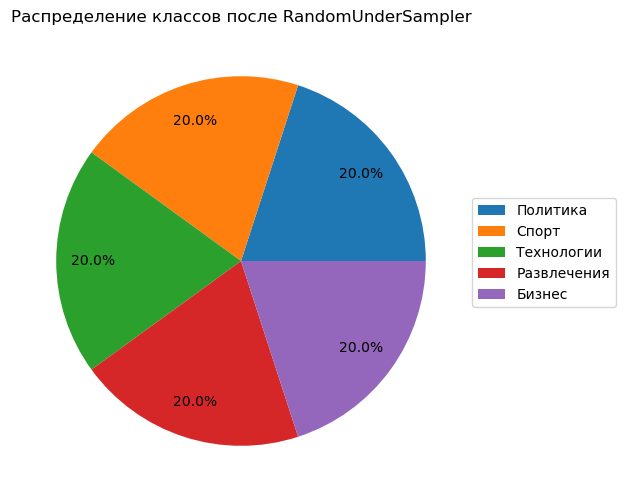

In [737]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [738]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [739]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [740]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [741]:
#######  Logistic Regression  #######
log_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=5)
log_grid_search.fit(X_train_scaled, y_train)
log_best_params = log_grid_search.best_params_

log = LogisticRegression(**log_best_params).fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf_param_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_params = rf_grid_search.best_params_

rf = RandomForestClassifier(**rf_best_params).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 4, 5],
                  'learning_rate': [0.1, 0.01, 0.001]}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid_search.best_params_

xgb = XGBClassifier(**xgb_best_params).fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm_param_grid = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'verbosity': [-1]}
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train_scaled, y_train)
lgbm_best_params = lgbm_grid_search.best_params_

lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
# CatBoost имеет встроенную настройку гиперпараметров, поэтому GridSearchCV не нужен
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
# Преобразование данных в тензоры float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры для поиска
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

net = NeuralNetClassifier(
    NeuralNetwork,
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    module__input_size=input_size,
    module__hidden_size=64,
    module__num_classes=num_classes,
    verbose=0
)

# Определение параметров для Grid Search
params = {
    'net__lr': [0.001, 0.01],
    'net__max_epochs': [50, 100],
    'net__module__hidden_size': [32, 64, 128],
}

# Pipeline и Grid Search
pipe = Pipeline([('net', net)])
gs = GridSearchCV(pipe, params, refit=True, cv=3, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
gs.fit(X_train_scaled.astype(np.float32), y_train.values)

# Лучшая модель
best_model = gs.best_estimator_.named_steps['net']

# Прогнозирование на тестовых данных
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    outputs = best_model.forward(X_test_scaled_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### Расчёт accuracy

In [742]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9633204633204633, 0.944015444015444, 0.9420849420849421, 0.944015444015444, 0.9478764478764479, 0.9652509652509652]


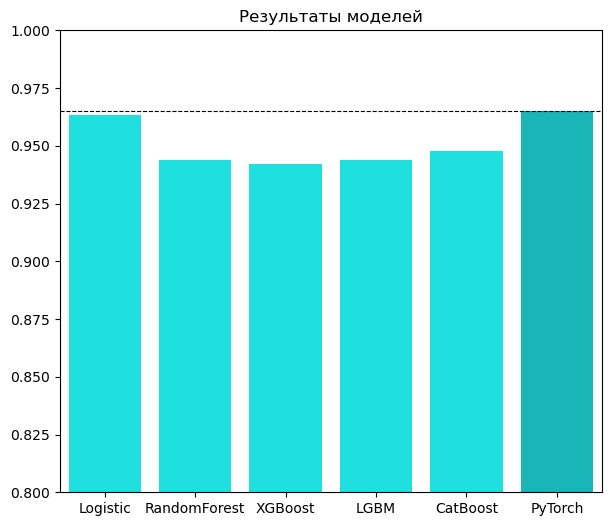

In [743]:
accuracy_list9 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list9)) else "darkturquoise" for i in accuracy_list9]
sns.barplot(x=np.arange(0,6), y=accuracy_list9, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list9)
plt.show()

In [744]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.94      0.97      0.95        95
           1       1.00      1.00      1.00       112
           2       0.97      0.97      0.97       101
           3       0.94      0.97      0.96       104
           4       0.96      0.91      0.93       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



In [745]:
# Вычисление классификационного отчета
class_report_pytorch = classification_report(y_test, y_pred_pytorch)

print("############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############\n")
print(class_report_pytorch)

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        95
           1       0.99      1.00      1.00       112
           2       0.96      0.96      0.96       101
           3       0.96      0.97      0.97       104
           4       0.96      0.92      0.94       106

    accuracy                           0.97       518
   macro avg       0.96      0.97      0.96       518
weighted avg       0.97      0.97      0.97       518



## Самые важные факторы

In [746]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

feature_importance         features
0                 379       caps_count
1                 357      text_length
2                 312              год
3                 270  stopwords_count
4                 238       word_count

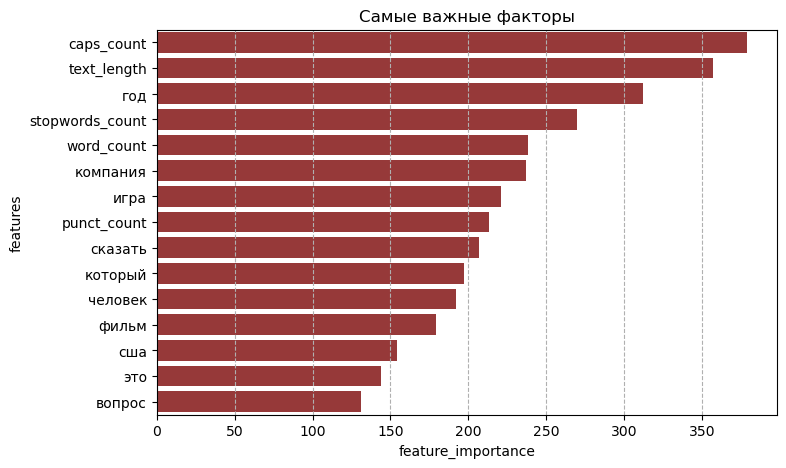

In [747]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самые важные факторы")
plt.grid(axis="x", ls="--")
plt.show()

### Очистка текста (10 метод - стемминг + 4-граммы)

In [748]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text10(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    stemmer = snowballstemmer.stemmer('russian')
    text = [stemmer.stemWord(word) for word in text]    
    n_grams = [' '.join(gram) for gram in ngrams(text, 4)]
    n_grams = " ".join(n_grams)
    return n_grams

df["cleaned_text"] = df["Text"].apply(clean_text10)

In [749]:
df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  
0  бюджет создан услов выбор создан услов выбор г...  
1  армейск вожд состав полк вожд состав полк ожид...  
2  говард отрица разбивк удостоверен отрица разби...  
3  наблюдател выбор соединен королевств выбор сое...  
4  килр назва выборн мест назва выборн мест бывш ...

## Статистика по тексту

In [750]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

Text  Label  \
0  Бюджет для создания условий для выборов\n \n Г...      0   
1  Армейские вожди в составе полков\n \n Ожидаетс...      0   
2  Говард отрицает разбивку на удостоверения личн...      0   
3  Наблюдатели за выборами в Соединенном Королевс...      0   
4  Килрой назвал выборное место\n \n Бывший орган...      0   

                                        cleaned_text  word_count  text_length  \
0  бюджет создан услов выбор создан услов выбор г...        1360         9667   
1  армейск вожд состав полк вожд состав полк ожид...        1140         8180   
2  говард отрица разбивк удостоверен отрица разби...        1312         9215   
3  наблюдател выбор соединен королевств выбор сое...        1348         9922   
4  килр назва выборн мест назва выборн мест бывш ...        1084         7328   

   stopwords_count  punct_count  caps_count  
0              108           86          57  
1              106           83          46  
2              123          109          63  
3              131           81          56  
4              106           96         109

In [751]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

word_count  text_length  stopwords_count  punct_count  caps_count
0  1104.138958  7729.816377       111.652605    88.933002   60.119107
1   719.904950  4645.500990        82.200000    68.780198   63.982178
2  1179.756522  8216.997101       113.455072    98.449275   72.304348
3   753.756098  4939.371274        72.604336    66.910569   67.260163
4   826.632207  5741.226640        72.391650    68.817097   55.952286

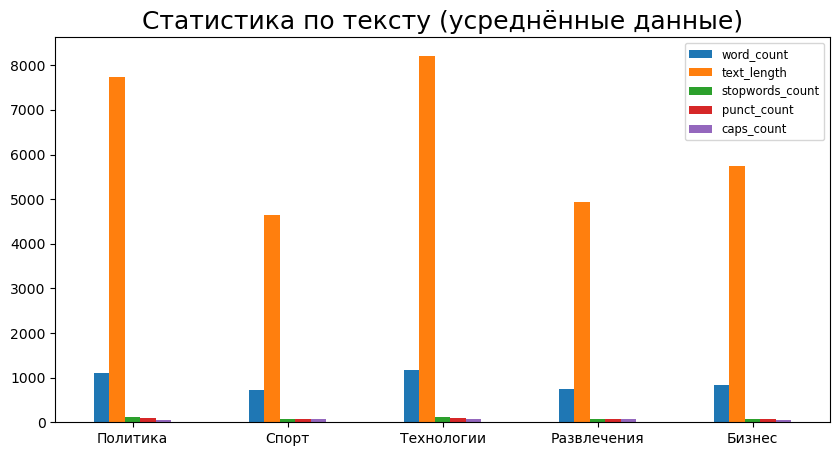

In [752]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

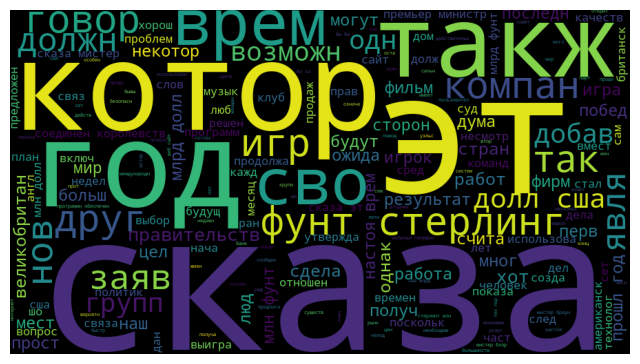

In [753]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [754]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

аббас  аборт  абсолютн  авар  август  авиакомпан  авиатор  авиац  авив  \
0      0      0         0     0       0           0        0      0     0   
1      0      0         0     0       0           0        0      0     0   
2      0      0         0     0       0           0        0      0     0   
3      0      0         0     0       0           0        0      0     0   
4      0      0         0     0       0           0        0      0     0   

   австр  ...  японск  ярд  ярк  ярлык  ярмарк  ясн  ях  ячв  ячейк  ящик  
0      0  ...       0    0    0      0       0    0   0    0      0     0  
1      0  ...       0    0    0      0       0    0   0    0      0     0  
2      0  ...       0    0    0      0       0    0   0    0      0     0  
3      0  ...       0    0    0      0       0    0   0    0      0     0  
4      0  ...       0    0    0      0       0    4   0    0      0     0  

[5 rows x 5000 columns]

In [755]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count
0      0        1360         9667              108           86          57
1      0        1140         8180              106           83          46
2      0        1312         9215              123          109          63
3      0        1348         9922              131           81          56
4      0        1084         7328              106           96         109

In [756]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

Label  word_count  text_length  stopwords_count  punct_count  caps_count  \
0      0        1360         9667              108           86          57   
1      0        1140         8180              106           83          46   
2      0        1312         9215              123          109          63   
3      0        1348         9922              131           81          56   
4      0        1084         7328              106           96         109   

   аббас  аборт  абсолютн  авар  ...  японск  ярд  ярк  ярлык  ярмарк  ясн  \
0      0      0         0     0  ...       0    0    0      0       0    0   
1      0      0         0     0  ...       0    0    0      0       0    0   
2      0      0         0     0  ...       0    0    0      0       0    0   
3      0      0         0     0  ...       0    0    0      0       0    0   
4      0      0         0     0  ...       0    0    0      0       0    4   

   ях  ячв  ячейк  ящик  
0   0    0      0     0  
1   0    0      0     0  
2   0    0      0     0  
3   0    0      0     0  
4   0    0      0     0  

[5 rows x 5006 columns]

## RandomUnderSampler

In [757]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

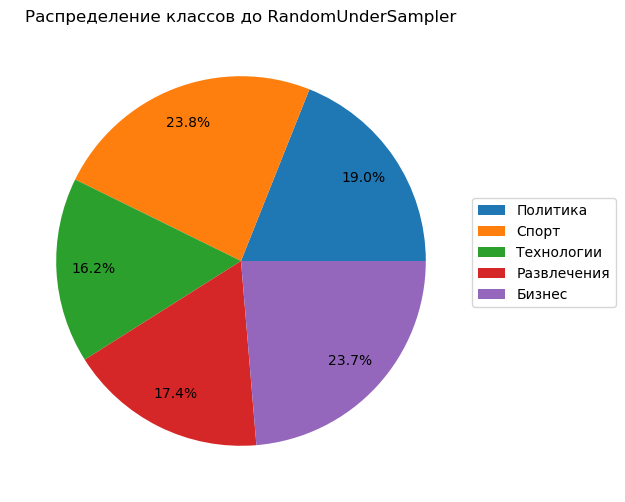

In [758]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [759]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

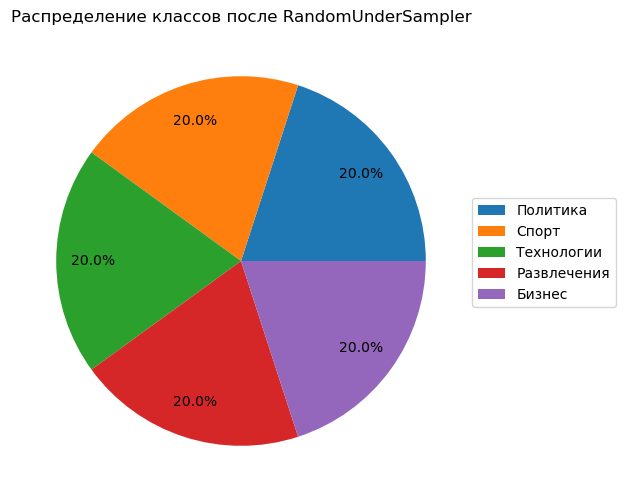

In [760]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [761]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [762]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [763]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [764]:
#######  Logistic Regression  #######
log_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=5)
log_grid_search.fit(X_train_scaled, y_train)
log_best_params = log_grid_search.best_params_

log = LogisticRegression(**log_best_params).fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf_param_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_params = rf_grid_search.best_params_

rf = RandomForestClassifier(**rf_best_params).fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 4, 5],
                  'learning_rate': [0.1, 0.01, 0.001]}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_params = xgb_grid_search.best_params_

xgb = XGBClassifier(**xgb_best_params).fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm_param_grid = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'verbosity': [-1]}
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train_scaled, y_train)
lgbm_best_params = lgbm_grid_search.best_params_

lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
# CatBoost имеет встроенную настройку гиперпараметров, поэтому GridSearchCV не нужен
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
# Преобразование данных в тензоры float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры для поиска
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train))

net = NeuralNetClassifier(
    NeuralNetwork,
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    module__input_size=input_size,
    module__hidden_size=64,
    module__num_classes=num_classes,
    verbose=0
)

# Определение параметров для Grid Search
params = {
    'net__lr': [0.001, 0.01],
    'net__max_epochs': [50, 100],
    'net__module__hidden_size': [32, 64, 128],
}

# Pipeline и Grid Search
pipe = Pipeline([('net', net)])
gs = GridSearchCV(pipe, params, refit=True, cv=3, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
gs.fit(X_train_scaled.astype(np.float32), y_train.values)

# Лучшая модель
best_model = gs.best_estimator_.named_steps['net']

# Прогнозирование на тестовых данных
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    outputs = best_model.forward(X_test_scaled_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### Расчёт accuracy

In [765]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9633204633204633, 0.9478764478764479, 0.9478764478764479, 0.9498069498069498, 0.9555984555984556, 0.9594594594594594]


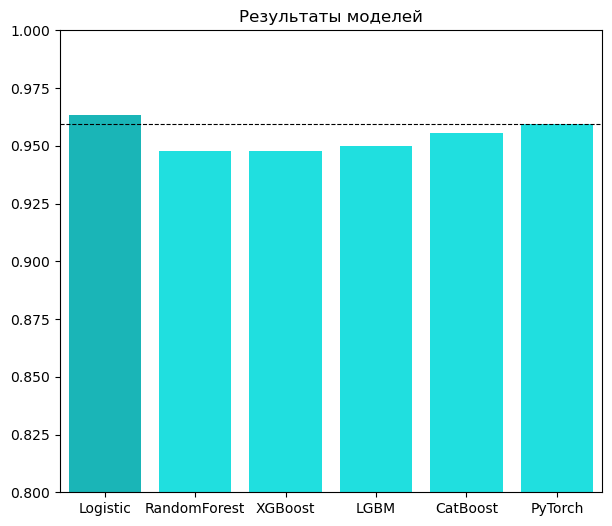

In [766]:
accuracy_list10 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list10)) else "darkturquoise" for i in accuracy_list10]
sns.barplot(x=np.arange(0,6), y=accuracy_list10, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list10)
plt.show()

In [767]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.94      0.97      0.95        95
           1       0.99      0.99      0.99       112
           2       0.98      0.95      0.96       101
           3       0.94      0.99      0.97       104
           4       0.96      0.92      0.94       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



In [768]:
# Вычисление классификационного отчета
class_report_pytorch = classification_report(y_test, y_pred_pytorch)

print("############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############\n")
print(class_report_pytorch)

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ PYTORCH  ############

              precision    recall  f1-score   support

           0       0.94      0.95      0.94        95
           1       0.98      1.00      0.99       112
           2       0.97      0.96      0.97       101
           3       0.96      0.97      0.97       104
           4       0.94      0.92      0.93       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самые важные факторы

In [769]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

feature_importance         features
0                 437       caps_count
1                 360      text_length
2                 318              год
3                 309  stopwords_count
4                 288       word_count

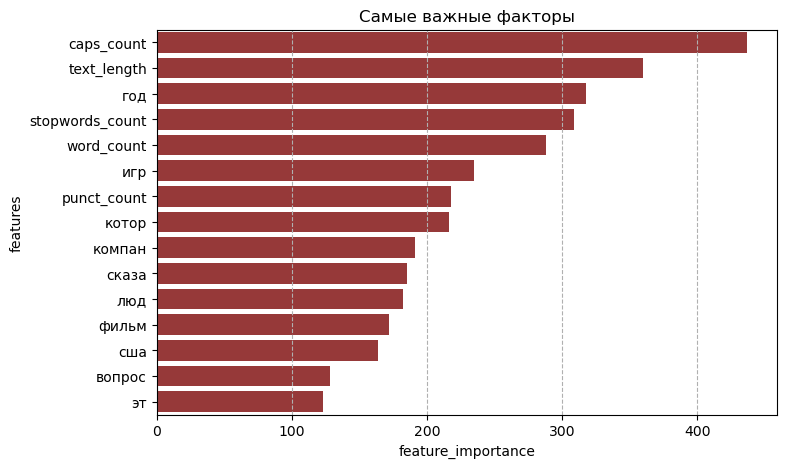

In [770]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самые важные факторы")
plt.grid(axis="x", ls="--")
plt.show()

## Результаты

Исследовав предложенные методы очистки текста на обучении 6 различных моделей, выяснилось, что самым эффективным методом является применение би-грамм и 4-грамм, так как n-граммы с другим n начинают переобучаться, следовательно, уменьшать необходимую нам accuracy, стемминг и лемматизация также уменьшают accuracy.

In [771]:
print(accuracy_list1)
print(accuracy_list11)
print(accuracy_list2)
print(accuracy_list3)
print(accuracy_list4)
print(accuracy_list5)
print(accuracy_list6)
print(accuracy_list7)
print(accuracy_list8)
print(accuracy_list9)
print(accuracy_list10)

[0.9633204633204633, 0.9305019305019305, 0.9324324324324325, 0.9478764478764479, 0.944015444015444, 0.9633204633204633]
[0.9613899613899614, 0.9324324324324325, 0.9343629343629344, 0.944015444015444, 0.9459459459459459, 0.9575289575289575]
[0.9575289575289575, 0.9498069498069498, 0.9420849420849421, 0.9459459459459459, 0.9401544401544402, 0.9633204633204633]
[0.9613899613899614, 0.9536679536679536, 0.9478764478764479, 0.9517374517374517, 0.9517374517374517, 0.9613899613899614]
[0.9633204633204633, 0.9343629343629344, 0.9343629343629344, 0.9401544401544402, 0.9478764478764479, 0.9575289575289575]
[0.9613899613899614, 0.9362934362934363, 0.9324324324324325, 0.9382239382239382, 0.9420849420849421, 0.9575289575289575]
[0.9613899613899614, 0.9343629343629344, 0.9227799227799228, 0.9420849420849421, 0.9459459459459459, 0.9613899613899614]
[0.9536679536679536, 0.9420849420849421, 0.9382239382239382, 0.9478764478764479, 0.9478764478764479, 0.9652509652509652]
[0.9633204633204633, 0.94980694980